<a href="https://colab.research.google.com/github/tanishi22/FYP/blob/main/Code/ML/multilabel_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Goal 1: Multilabel Essentiality Prediction with 5-fold Cross Validation: Intrinsic and Extrinsic Features**

This notebook aims to perform multilabel classification of essential vs non-essential genes from Drosophila melanogaster using both extrinsic and intrinsic gene features.

**Intrinsic features (n = 10020)** and **extrinsic features (n = 107)** across all **essential (n = 2081)** and **non-essential genes (n = 3764)** have been extracted and merged into dataframes called intrinsic_df and extrinsic_df, respectively. These dataframes have all the corresponding essentiality labels for the FBgn_IDs.

**Classifiers:** Logistic Regression (LR), Support Vector Machine (SVM), Random Forest (RF), Gradient Boosting Model (GBM), Xtreme Gradient Boosting (XGB), and a Multi-Layer Perceptron (MLP) Classifier (simple neural network)

# **Goal 2: Determining Per-label Feature Importances from Multi-label Classification**
Working with the targeted SMOTE at this point, because it gave the 'best' subset accuracies and was used to determine the per-label F1 scores that were reported in the results

Will be calculating per-label permutation importance and visualising this hopefully as a heatmap or UpSet plot?

# **Load Dependencies**

In [ ]:
!pip install iterative-stratification

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, SelectFromModel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, make_scorer, f1_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.dummy import DummyClassifier
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, MultilabelStratifiedShuffleSplit
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.feature_selection import f_classif, VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, accuracy_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Prevent harmless sklearn warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# **Load and Merge Feature Data**

In [ ]:
# change file paths accordingly
intrinsic_file_path = "/content/drive/My Drive/ICL/FYP/Data/intrinsic_df.csv"
extrinsic_file_path = "/content/drive/My Drive/ICL/FYP/Data/extrinsic_df.csv"

In [ ]:
# Load intrinsic data and inspect dimensions and labels
intrinsic_df = pd.read_csv(intrinsic_file_path)
intrinsic_df.head()

,Unnamed: 0,FBgn_ID,gc_content,theoretical_pi,Tiny,Small,Aliphatic,Aromatic,Non.polar,Polar,...,Num_Isoforms,Longest_Isoform_Length,mode_chromosome_name,gene_length,coding_gene_length,five_utr_length,three_utr_length,cdna_coding_length,exon_chrom_length,label
0,0,FBgn0010612,0.583333,4.759690,0.303030,0.505051,0.272727,0.101010,0.626263,0.373737,...,3.0,300.0,2L,878.0,150.000000,26.5,380.0,150.000000,244.333333,1
1,1,FBgn0003517,0.622386,9.776537,0.266667,0.525926,0.229630,0.100000,0.540741,0.459259,...,4.0,813.0,X,1617.0,406.500000,132.0,90.0,406.500000,517.500000,1
2,2,FBgn0015376,0.519450,5.507063,0.273917,0.485398,0.199396,0.099698,0.491440,0.508560,...,1.0,2982.0,2L,4519.0,248.500000,130.0,124.0,248.500000,269.666667,1
3,3,FBgn0004868,0.573574,8.674255,0.259594,0.469526,0.225734,0.117381,0.539503,0.460497,...,3.0,1332.0,2L,3701.0,444.000000,181.0,148.0,444.000000,553.666667,1
4,4,FBgn0013733,0.526800,5.500341,0.261442,0.481772,0.227144,0.065531,0.457240,0.542760,...,22.0,26418.0,2R,77874.0,978.444444,153.5,1117.0,978.444444,994.357143,1


In [ ]:
# Drop any unnamed index column
intrinsic_features = intrinsic_df.drop(columns=[col for col in ['Unnamed: 0'] if col in intrinsic_df.columns])
intrinsic_features.head()

,FBgn_ID,gc_content,theoretical_pi,Tiny,Small,Aliphatic,Aromatic,Non.polar,Polar,Charged,...,Num_Isoforms,Longest_Isoform_Length,mode_chromosome_name,gene_length,coding_gene_length,five_utr_length,three_utr_length,cdna_coding_length,exon_chrom_length,label
0,FBgn0010612,0.583333,4.759690,0.303030,0.505051,0.272727,0.101010,0.626263,0.373737,0.191919,...,3.0,300.0,2L,878.0,150.000000,26.5,380.0,150.000000,244.333333,1
1,FBgn0003517,0.622386,9.776537,0.266667,0.525926,0.229630,0.100000,0.540741,0.459259,0.259259,...,4.0,813.0,X,1617.0,406.500000,132.0,90.0,406.500000,517.500000,1
2,FBgn0015376,0.519450,5.507063,0.273917,0.485398,0.199396,0.099698,0.491440,0.508560,0.278953,...,1.0,2982.0,2L,4519.0,248.500000,130.0,124.0,248.500000,269.666667,1
3,FBgn0004868,0.573574,8.674255,0.259594,0.469526,0.225734,0.117381,0.539503,0.460497,0.288939,...,3.0,1332.0,2L,3701.0,444.000000,181.0,148.0,444.000000,553.666667,1
4,FBgn0013733,0.526800,5.500341,0.261442,0.481772,0.227144,0.065531,0.457240,0.542760,0.308234,...,22.0,26418.0,2R,77874.0,978.444444,153.5,1117.0,978.444444,994.357143,1


In [ ]:
# Load extrinsic data and inspect shape
extrinsic_df = pd.read_csv(extrinsic_file_path)
extrinsic_df.head()
# Drop any unnamed index column
extrinsic_features = extrinsic_df.drop(columns=[col for col in ['Unnamed: 0'] if col in extrinsic_df.columns])
extrinsic_features.head()

,FBgn_ID,biological_process,cellular_component,molecular_function,goslim_terms,ensembl_peptide_id,signalp_prediction,signalp_other,signalp_sp_sec_spi,Localizations,...,Degree Centrality,Closeness Centrality,Betweenness Centrality,Eigenvector Centrality,Average Neighbor Degree,Clustering Coefficient,Triangle Count,Core Number,Louvain Community,label
0,FBgn0000008,1.0,2.0,2.0,['anatomical structure development'],FBpp0071678,OTHER,1.0,0.000002,"['Cytoplasm', 'Cell membrane']",...,0.000158,0.218239,0.000000,2.880723e-05,42.000000,0.000000,0.0,1.0,17.0,1
1,FBgn0000014,260.0,40.0,70.0,"['organelle', 'nucleus', 'DNA binding', 'trans...",FBpp0082829,OTHER,1.0,0.000000,['Nucleus'],...,0.025685,0.315579,0.012630,1.000753e-03,23.067485,0.038703,511.0,12.0,12.0,1
2,FBgn0000015,234.0,18.0,45.0,"['organelle', 'nucleus', 'DNA binding', 'anato...",FBpp0082826,OTHER,1.0,0.000002,['Nucleus'],...,0.006461,0.273769,0.000486,1.054210e-04,26.878049,0.135366,111.0,11.0,12.0,1
3,FBgn0000017,35.0,0.0,25.0,"['anatomical structure development', 'catalyti...",FBpp0303166,OTHER,1.0,0.000001,"['Cytoplasm', 'Cell membrane']",...,0.003309,0.267418,0.001300,6.153944e-05,23.000000,0.095238,20.0,8.0,32.0,1
4,FBgn0000018,28.0,21.0,21.0,"['organelle', 'chromosome', 'nucleus', 'regula...",FBpp0079757,OTHER,1.0,0.000000,['Nucleus'],...,0.000158,0.195339,0.000000,9.168425e-07,9.000000,0.000000,0.0,1.0,17.0,1


In [ ]:
# Merge extrinsic and intrinsic features into a single feature matrix by FBgn_ID
feature_matrix = intrinsic_features.merge(extrinsic_features, on = ['FBgn_ID', 'label'], how = 'inner')
# Inspect final labels: 2076 essential genes and 3763 non-essential genes
print(feature_matrix["label"].value_counts(dropna=False))

label
0    3763
1    2076
Name: count, dtype: int64


In [ ]:
import ast

# Convert the string representation of lists to actual lists
feature_matrix['Signals'] = feature_matrix['Signals'].apply(ast.literal_eval)
feature_matrix['Localizations'] = feature_matrix['Localizations'].apply(ast.literal_eval)
feature_matrix['goslim_terms'] = feature_matrix['goslim_terms'].apply(ast.literal_eval)

In [ ]:
# drop original binary labels
feature_matrix = feature_matrix.drop(columns=[col for col in ['label'] if col in feature_matrix.columns])
feature_matrix.head()

,FBgn_ID,gc_content,theoretical_pi,Tiny,Small,Aliphatic,Aromatic,Non.polar,Polar,Charged,...,Degree,Degree Centrality,Closeness Centrality,Betweenness Centrality,Eigenvector Centrality,Average Neighbor Degree,Clustering Coefficient,Triangle Count,Core Number,Louvain Community
0,FBgn0010612,0.583333,4.759690,0.303030,0.505051,0.272727,0.101010,0.626263,0.373737,0.191919,...,14.0,0.002206,0.237994,0.000040,0.000059,25.500000,0.648352,59.0,11.0,0.0
1,FBgn0003517,0.622386,9.776537,0.266667,0.525926,0.229630,0.100000,0.540741,0.459259,0.259259,...,97.0,0.015285,0.281369,0.000419,0.105178,89.721649,0.819373,3815.0,87.0,19.0
2,FBgn0015376,0.519450,5.507063,0.273917,0.485398,0.199396,0.099698,0.491440,0.508560,0.278953,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FBgn0004868,0.573574,8.674255,0.259594,0.469526,0.225734,0.117381,0.539503,0.460497,0.288939,...,34.0,0.005358,0.273591,0.003294,0.001596,51.147059,0.251337,141.0,20.0,3.0
4,FBgn0013733,0.526800,5.500341,0.261442,0.481772,0.227144,0.065531,0.457240,0.542760,0.308234,...,11.0,0.001733,0.250274,0.000194,0.000201,19.636364,0.072727,4.0,7.0,17.0


In [ ]:
# load multilabel df to add all relevant labels
multilabel_filepath = "/content/drive/My Drive/ICL/FYP/Data/multilabel_df.csv"
multilabel_df = pd.read_csv(multilabel_filepath)

multilabel_df.rename(columns={'Unnamed: 0': 'FBgn_ID'}, inplace=True)
multilabel_df.head()

,FBgn_ID,lethal,sterile,dominant,recessive,essential
0,FBgn0020653,1,0,0,1,1
1,FBgn0263395,1,0,0,1,1
2,FBgn0027504,1,0,0,1,1
3,FBgn0003687,1,0,0,1,1
4,FBgn0086695,1,1,0,1,1


In [ ]:
# merge with feature matrix on FBgn_ID
multi_feature_matrix = feature_matrix.merge(multilabel_df, on = 'FBgn_ID', how = 'left')
multi_feature_matrix['essential'] # check if annotations are present (lethal, sterile, dominant, recessive, essential )

,essential
0,1
1,1
2,1
3,1
4,1
...,...
5834,0
5835,0
5836,0
5837,0


In [ ]:
# drop FBgn_ID and ensembl_peptide ID -- irrelevant now
multi_feature_matrix = multi_feature_matrix.drop(columns=[col for col in ['FBgn_ID', 'ensembl_peptide_id'] if col in multi_feature_matrix.columns])
multi_feature_matrix.head() # total 10125 features !

,gc_content,theoretical_pi,Tiny,Small,Aliphatic,Aromatic,Non.polar,Polar,Charged,Basic,...,Average Neighbor Degree,Clustering Coefficient,Triangle Count,Core Number,Louvain Community,lethal,sterile,dominant,recessive,essential
0,0.583333,4.759690,0.303030,0.505051,0.272727,0.101010,0.626263,0.373737,0.191919,0.131313,...,25.500000,0.648352,59.0,11.0,0.0,1,0,0,1,1
1,0.622386,9.776537,0.266667,0.525926,0.229630,0.100000,0.540741,0.459259,0.259259,0.111111,...,89.721649,0.819373,3815.0,87.0,19.0,1,0,0,1,1
2,0.519450,5.507063,0.273917,0.485398,0.199396,0.099698,0.491440,0.508560,0.278953,0.154079,...,NaN,NaN,NaN,NaN,NaN,1,0,0,1,1
3,0.573574,8.674255,0.259594,0.469526,0.225734,0.117381,0.539503,0.460497,0.288939,0.142212,...,51.147059,0.251337,141.0,20.0,3.0,1,0,0,1,1
4,0.526800,5.500341,0.261442,0.481772,0.227144,0.065531,0.457240,0.542760,0.308234,0.151732,...,19.636364,0.072727,4.0,7.0,17.0,1,0,0,1,1


# **Data Splitting and Multilabel Preprocessors**

In [ ]:
# define multilabel cols and define X and y
label_cols = ['lethal', 'sterile', 'dominant', 'recessive', 'essential']
X = multi_feature_matrix.drop(columns=label_cols)
y = multi_feature_matrix[label_cols]

In [ ]:
# check datatypes per column
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical columns: {len(num_cols)}") # n = 10116
print(f"Categorical columns: {len(cat_cols)}") # n = 8

Numerical columns: 10116
Categorical columns: 8


In [ ]:
# You may need to adjust these based on your actual DataFrame dtypes.
numerical_cols   = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

In [ ]:
# Split categorical columns into two types, as different types of preprocessing will be applied on them
# will need to create individual transformers in the preprocessor for these columns
multilabel_cols = ['goslim_terms', 'Localizations', 'Signals']
onehot_cols = [col for col in categorical_cols if col not in multilabel_cols]

In [ ]:
print("Numeric columns:", len(numerical_cols))
print("One-hot columns:", len(onehot_cols))
print("Multi‐label list columns:", multilabel_cols)

Numeric columns: 10116
One-hot columns: 5
Multi‐label list columns: ['goslim_terms', 'Localizations', 'Signals']


In [ ]:
# Define custom MultiLabelBinarizerTransformer that can be wrapped around MULTIPLE multi-label columns
class MultiLabelBinarizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, classes=None):
        self.classes = classes
        self.mlb = MultiLabelBinarizer(classes=self.classes)

    def fit(self, X, y=None):
        if self.classes is None:
            all_labels = set(label for row in X.iloc[:, 0] for label in row)
            self.classes = sorted(all_labels)
            self.mlb = MultiLabelBinarizer(classes=self.classes)
        self.mlb.fit(X.iloc[:, 0])
        return self

    def transform(self, X):
        return self.mlb.transform(X.iloc[:, 0])

In [ ]:
# Create pre-processing transformer for numerical and categorical features. Will be input into ColumnTransformer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

multilabel_transformer = [
    (f'mlb_{col}', Pipeline([
        ('mlb', MultiLabelBinarizerTransformer())
    ]), [col]) for col in multilabel_cols
]

# Combine transformers in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('onehot', onehot_transformer, onehot_cols),
    ] + multilabel_transformer
)

In [ ]:
# ==============================================================================
# STEP E: Define MultiLabelSelectKBest
#
# This transformer will:
#  1. For each of your 5 labels j=0..4, compute (F_scores_j, p_values_j) = f_classif(X, y[:,j])
#  2. Aggregate the five F_scores_j into one array of length n_features,
#     e.g. by taking the MEAN across labels: F_mean[i] = (F_i,0 + F_i,1 + ... + F_i,4)/5
#  3. Keep only the top k features by largest F_mean.
# ==============================================================================
class MultiLabelSelectKBest(BaseEstimator, TransformerMixin):
    def __init__(self, k=500):
        self.k = k
        self.scores_ = None    # aggregated F-scores
        self.pvalues_ = None   # aggregated p-values (not used downstream, but stored)
        self.support_mask_ = None

    def fit(self, X, y):
        """
        X: 2D array or DataFrame of shape (n_samples, n_features)
        y: 2D array of shape (n_samples, n_labels=5)
        """
        # If X is a DataFrame, extract values and keep feature names
        if isinstance(X, pd.DataFrame):
            X_arr = X.values
            self.feature_names_in_ = X.columns.to_list()
        else:
            X_arr = X
            self.feature_names_in_ = None

        n_features = X_arr.shape[1]
        n_labels = y.shape[1]

        # Compute f_classif for each label separately
        all_F = np.zeros((n_labels, n_features))
        all_p = np.zeros((n_labels, n_features))

        for j in range(n_labels):
            F_j, p_j = f_classif(X_arr, y[:, j])
            all_F[j, :] = F_j
            all_p[j, :] = p_j

        # Aggregate F-scores (e.g. mean) across labels
        self.scores_ = np.mean(all_F, axis=0)
        self.pvalues_ = np.mean(all_p, axis=0)

        # Pick top k features by descending aggregated F-score
        idx_sorted = np.argsort(self.scores_)[::-1]
        topk_idx = idx_sorted[: self.k]

        mask = np.zeros(n_features, dtype=bool)
        mask[topk_idx] = True
        self.support_mask_ = mask  # boolean mask of length n_features

        return self

    def transform(self, X):
        """
        Apply the top-k mask to X. Returns X[:, support_mask_].
        """
        if isinstance(X, pd.DataFrame):
            return X.iloc[:, self.support_mask_].values
        else:
            return X[:, self.support_mask_]

    def get_support(self, indices=False):
        """
        Return either the boolean mask or the indices of selected features.
        """
        if indices:
            return np.where(self.support_mask_)[0]
        return self.support_mask_


In [ ]:
# ==============================================================================
# STEP F: Define MultiLabelSelectFromModel
#
# This will:
#  1. Fit `MultiOutputClassifier(ExtraTreesClassifier)` on (X, y), where y is (n,5).
#  2. Each of the 5 internal ExtraTrees models has feature_importances_ (length n_features).
#  3. We average those 5 importance vectors into one array of length n_features.
#  4. We threshold: keep features whose average_importance >= threshold. By default, threshold = mean_importance.
# ==============================================================================
class MultiLabelSelectFromModel(BaseEstimator, TransformerMixin):
    def __init__(self,
                 base_estimator=None,
                 threshold=None,
                 max_features=None,
                 random_state=42):
        """
        base_estimator: an sklearn estimator with feature_importances_ (e.g. ExtraTreesClassifier())
        threshold: float or None. If None, use mean of importances.
        max_features: if not None, override threshold to select exactly max_features top features.
        """
        self.base_estimator = base_estimator
        self.threshold = threshold
        self.max_features = max_features
        self.random_state = random_state

        self.average_importances_ = None
        self.support_mask_ = None

    def fit(self, X, y):
        """
        X: array or DataFrame of shape (n_samples, n_features)
        y: array of shape (n_samples, n_labels=5)
        """
        # If X is a DataFrame, keep track of columns
        if isinstance(X, pd.DataFrame):
            X_arr = X.values
            self.feature_names_in_ = X.columns.to_list()
        else:
            X_arr = X
            self.feature_names_in_ = None

        # Build a MultiOutputClassifier around the base_estimator
        if self.base_estimator is None:
            base = ExtraTreesClassifier(n_estimators=100, class_weight='balanced', random_state=self.random_state)
        else:
            base = self.base_estimator

        moc = MultiOutputClassifier(base, n_jobs=-1)
        moc.fit(X_arr, y)

        # Each estimator in moc.estimators_ has feature_importances_
        importances = np.vstack([
            est.feature_importances_ for est in moc.estimators_
        ])
        # Average across the n_labels dimension → shape (n_features,)
        self.average_importances_ = np.mean(importances, axis=0)

        # Determine threshold
        if self.max_features is not None:
            # pick top max_features features by importance
            idx_sorted = np.argsort(self.average_importances_)[::-1]
            chosen_idx = idx_sorted[: self.max_features]
            mask = np.zeros_like(self.average_importances_, dtype=bool)
            mask[chosen_idx] = True
        else:
            if self.threshold is None:
                thr = np.mean(self.average_importances_)
            else:
                thr = self.threshold
            mask = self.average_importances_ >= thr

        self.support_mask_ = mask
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X.iloc[:, self.support_mask_].values
        else:
            return X[:, self.support_mask_]

    def get_support(self, indices=False):
        if indices:
            return np.where(self.support_mask_)[0]
        return self.support_mask_


In [ ]:
ml_kbest = MultiLabelSelectKBest(k=500)
ml_selmodel = MultiLabelSelectFromModel(
    base_estimator=ExtraTreesClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    max_features=100  # or threshold=None if you prefer a threshold
)

In [ ]:
def get_selected_feature_names(pipeline, numerical_cols, onehot_cols, multilabel_transformers):
    """
    Returns a list of the final feature names that reach the classifier, after:
      1) preprocessing (ColumnTransformer with numeric, one‐hot, and MultiLabelBinarizer steps)
      2) VarianceThreshold
      3) SelectKBest
      4) SelectFromModel

    Arguments:
      pipeline                — your fitted Pipeline object:
                                [ 'preprocessing', 'variance', 'select_kbest', 'select_model', 'clf' ]
      numerical_cols          — list of original numeric column names
      onehot_cols             — list of original one‐hot categorical column names
      multilabel_transformers — list of tuples describing your multilabel steps,
                                e.g. [ ('mlb_goslim', transformer, ['goslim_terms']), ... ]

    Returns:
      A Python list of strings (length = number of selected features).
    """
    pre = pipeline.named_steps['preprocessing']

    # 1) Numeric features remain unchanged by imputer+scaler
    num_features = list(numerical_cols)

    # 2) OneHotEncoder step: get names of the dummy columns it created
    ohe = pre.named_transformers_['onehot'].named_steps['onehot']
    ohe_features = ohe.get_feature_names_out(onehot_cols).tolist()

    # 3) MultiLabelBinarizer steps: each generates one column per class
    mlb_features = []
    for (mlb_name, _, cols) in multilabel_transformers:
        mlb = pre.named_transformers_[mlb_name].named_steps['mlb']
        # Suppose cols = ['goslim_terms'], then for each class 'X' in mlb.classes_
        # we get a final feature name 'goslim_terms_X'
        for cls in mlb.mlb.classes_:
            mlb_features.append(f"{cols[0]}_{cls}")

    # Combine into the full list of columns after preprocessing
    all_preprocessed = num_features + ohe_features + mlb_features

    # 4) Apply VarianceThreshold mask
    var_mask = pipeline.named_steps['variance'].get_support()
    after_var = [f for f, keep in zip(all_preprocessed, var_mask) if keep]

    # 5) Apply SelectKBest mask
    kbest_mask = pipeline.named_steps['select_kbest'].get_support()
    after_kb = [f for f, keep in zip(after_var, kbest_mask) if keep]

    # 6) Apply SelectFromModel mask
    model_mask = pipeline.named_steps['select_model'].get_support()
    final_feats = [f for f, keep in zip(after_kb, model_mask) if keep]

    return final_feats


# **Random Forest MultiLabel Classification**

In [ ]:
base_rf = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf',    RandomForestClassifier(
                  n_estimators=100,
                  class_weight='balanced',
                  random_state=42
              ))
])

ovr_clf = OneVsRestClassifier(base_rf, n_jobs=-1)

In [ ]:
# ─── D) Create a “wrapper” pipeline that does feature selection before OVR ─────
multi_label_pipeline = Pipeline([
    ('preprocessing', preprocessor),   # transforms X into a dense array
    ('variance',      VarianceThreshold(threshold=0.01)),
    ('select_kbest',  ml_kbest),
    ('select_model',  ml_selmodel),
    ('ovr',           ovr_clf)
], verbose = True)

In [ ]:
# ==============================================================================
# STEP I: Now run a 5-fold Multilabel-Stratified CV using the full pipeline
# ==============================================================================
mlskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []
fold_reports = []

for fold, (train_idx, test_idx) in enumerate(mlskf.split(X, y), start=1):
    X_tr, X_te = X.iloc[train_idx].reset_index(drop=True), X.iloc[test_idx].reset_index(drop=True)
    y_tr, y_te = y.iloc[train_idx].reset_index(drop=True), y.iloc[test_idx].reset_index(drop=True)

    print(f"\n--- Fold {fold} ---")
    print("  Train label counts:", y_tr.sum(axis=0).to_dict())
    print("  Test  label counts:", y_te.sum(axis=0).to_dict())

    # Fit on this fold’s training data
    multi_label_pipeline.fit(X_tr, y_tr.values)

    # Predict on this fold’s test data (no SMOTE on test)
    y_pred = multi_label_pipeline.predict(X_te)

    # Compute subset‐accuracy
    acc = accuracy_score(y_te.values, y_pred)
    fold_accuracies.append(acc)

    print(f"  Fold {fold} subset‐accuracy: {acc:.4f}")
    print("  Classification report (test):")
    report = classification_report(
        y_te.values,
        y_pred,
        target_names=label_cols,
        zero_division=0
    )
    print(report)
    fold_reports.append(report)

# Summarize CV
mean_acc = np.mean(fold_accuracies)
std_acc  = np.std(fold_accuracies)
print(f"\n===== 5-Fold Multilabel-Stratified CV Results =====")
print(f"Mean subset-accuracy: {mean_acc:.4f} ± {std_acc:.4f}")



--- Fold 1 ---
  Train label counts: {'lethal': 1540, 'sterile': 331, 'dominant': 42, 'recessive': 1657, 'essential': 1661}
  Test  label counts: {'lethal': 383, 'sterile': 82, 'dominant': 10, 'recessive': 414, 'essential': 415}
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.5s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.3s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   6.7s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=  18.0s
[Pipeline] ............... (step 5 of 5) Processing ovr, total=  33.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['nitrogen cycle metabolic process'] will be ignored
  warnings.warn(


  Fold 1 subset‐accuracy: 0.7842
  Classification report (test):
              precision    recall  f1-score   support

      lethal       0.76      0.88      0.82       383
     sterile       0.51      0.23      0.32        82
    dominant       0.50      0.10      0.17        10
   recessive       0.80      0.88      0.84       414
   essential       0.78      0.90      0.84       415

   micro avg       0.77      0.84      0.81      1304
   macro avg       0.67      0.60      0.60      1304
weighted avg       0.76      0.84      0.79      1304
 samples avg       0.32      0.30      0.30      1304


--- Fold 2 ---
  Train label counts: {'lethal': 1532, 'sterile': 330, 'dominant': 42, 'recessive': 1657, 'essential': 1661}
  Test  label counts: {'lethal': 391, 'sterile': 83, 'dominant': 10, 'recessive': 414, 'essential': 415}
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.2s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.2s
[Pipeline] ...... (s

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['toxin activity'] will be ignored
  warnings.warn(


  Fold 3 subset‐accuracy: 0.7680
  Classification report (test):
              precision    recall  f1-score   support

      lethal       0.75      0.88      0.81       385
     sterile       0.44      0.17      0.25        82
    dominant       0.00      0.00      0.00        11
   recessive       0.78      0.89      0.83       414
   essential       0.77      0.88      0.82       415

   micro avg       0.76      0.83      0.79      1307
   macro avg       0.55      0.57      0.54      1307
weighted avg       0.74      0.83      0.78      1307
 samples avg       0.32      0.30      0.30      1307


--- Fold 4 ---
  Train label counts: {'lethal': 1540, 'sterile': 330, 'dominant': 41, 'recessive': 1656, 'essential': 1661}
  Test  label counts: {'lethal': 383, 'sterile': 83, 'dominant': 11, 'recessive': 415, 'essential': 415}
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   4.5s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.5s
[Pipeline] ...... (s

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['inflammatory response'] will be ignored
  warnings.warn(


  Fold 4 subset‐accuracy: 0.7763
  Classification report (test):
              precision    recall  f1-score   support

      lethal       0.73      0.91      0.81       383
     sterile       0.38      0.16      0.22        83
    dominant       0.00      0.00      0.00        11
   recessive       0.76      0.92      0.83       415
   essential       0.78      0.92      0.84       415

   micro avg       0.75      0.86      0.80      1307
   macro avg       0.53      0.58      0.54      1307
weighted avg       0.73      0.86      0.78      1307
 samples avg       0.33      0.31      0.31      1307


--- Fold 5 ---
  Train label counts: {'lethal': 1542, 'sterile': 330, 'dominant': 42, 'recessive': 1657, 'essential': 1660}
  Test  label counts: {'lethal': 381, 'sterile': 83, 'dominant': 10, 'recessive': 414, 'essential': 416}
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.2s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.4s
[Pipeline] ...... (s

In [ ]:
# Extracting the reduced feature set
# Step through the same transforms **up to** but not including 'ovr'
pre       = multi_label_pipeline.named_steps['preprocessing']
var       = multi_label_pipeline.named_steps['variance']
kbest     = multi_label_pipeline.named_steps['select_kbest']
selmodel  = multi_label_pipeline.named_steps['select_model']

# For training set (so SHAP or permutation sees the same distribution the model was trained on)
X_pre_train = pre.transform(X_train)      # → shape (n_train, n_after_preproc)
X_var_train = var.transform(X_pre_train)  # → shape (n_train, n_after_variance)
X_kb_train  = kbest.transform(X_var_train) # → shape (n_train, 500)
X_sel_train = selmodel.transform(X_kb_train) # → shape (n_train, n_selected ≈ 84)

# For test set
X_pre_test = pre.transform(X_test)
X_var_test = var.transform(X_pre_test)
X_kb_test  = kbest.transform(X_var_test)
X_sel_test = selmodel.transform(X_kb_test)  # → shape (n_test, n_selected ≈ 84)


In [ ]:
feature_names = get_selected_feature_names(
    multi_label_pipeline,
    numerical_cols,
    onehot_cols,
    multilabel_transformer
)
# feature_names is a list of length ≈84 in the exact order of X_sel_train’s columns


In [ ]:
# Computing per-label permutation importance
from sklearn.inspection import permutation_importance

def per_label_perm_importance(ovr_clf, X_sel, y_test_df, feature_names, top_n=10, scoring='roc_auc'):
    """
    Returns a dict mapping each label → its sorted permutation‐importance DataFrame.
    Optionally, also plots the top_n features per label.
    """
    results = {}
    label_names = y_test_df.columns.tolist()  # ['lethal','sterile','dominant','recessive','essential']

    for i, lab in enumerate(label_names):
        # 5.A) Extract binary labels for this phenotype
        y_bin = y_test_df[lab].values  # shape (n_test,)

        # 5.B) Grab the fitted sub-pipeline for label i
        subpipe = ovr_clf.estimators_[i]
        # subpipe is something like: Pipeline([('smote',SMOTE),('rf',RandomForestClassifier)])
        # Already fitted on X_sel_train and y_train[:,i]

        # 5.C) Compute permutation importance on X_sel_test
        perm = permutation_importance(
            subpipe,
            X_sel,
            y_bin,
            n_repeats=5,
            random_state=42,
            scoring=scoring,
            n_jobs=-1
        )
        imp_vals = perm.importances_mean  # length n_selected

        df_imp = pd.DataFrame({
            'feature': feature_names,
            'importance': imp_vals
        }).sort_values(by='importance', ascending=False).reset_index(drop=True)

        results[lab] = df_imp

        # 5.D) (Optional) Plot the top_n for this label
        plt.figure(figsize=(8, 4))
        top_df = df_imp.head(top_n).iloc[::-1]  # reverse for horizontal bar
        plt.barh(top_df['feature'], top_df['importance'], color='skyblue')
        plt.xlabel(f"Mean drop in {scoring}")
        plt.ylabel("Feature")
        plt.title(f"Permutation Importance for '{lab}' (Top {top_n})")
        plt.tight_layout()
        plt.show()

    return results


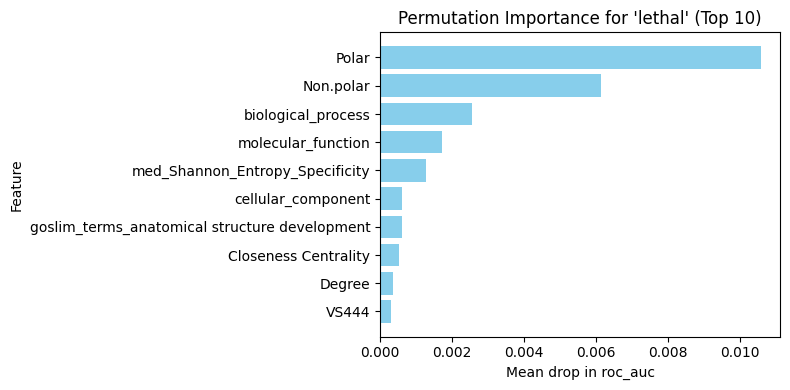

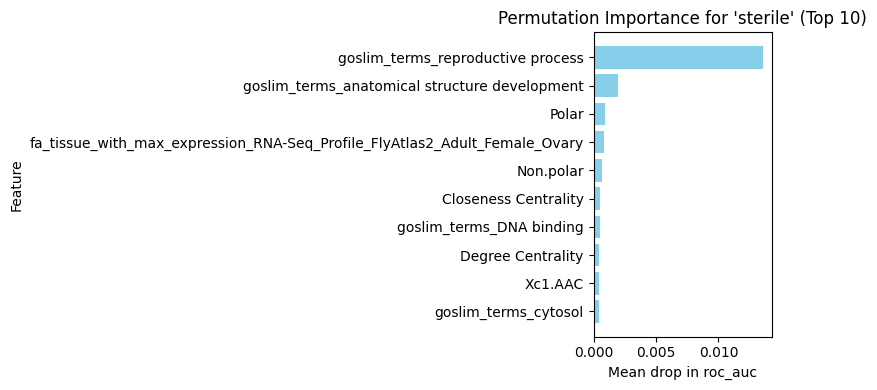

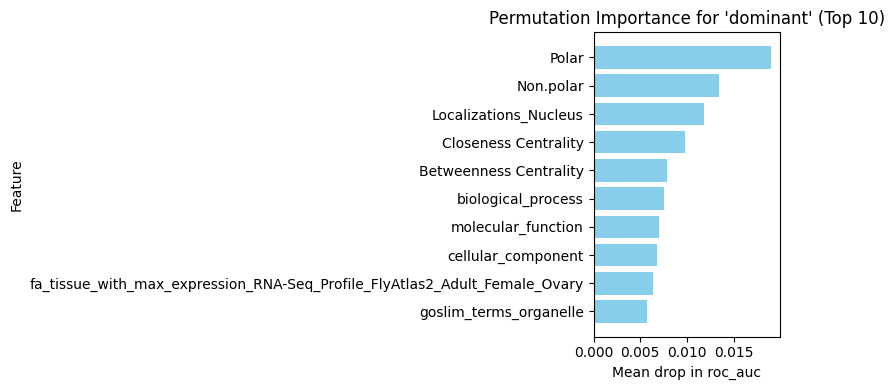

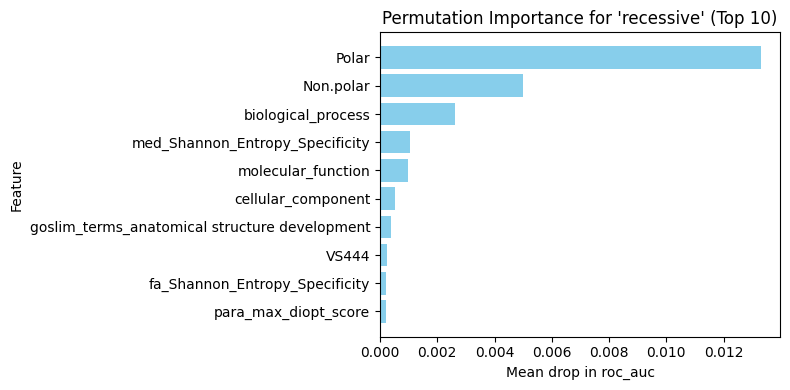

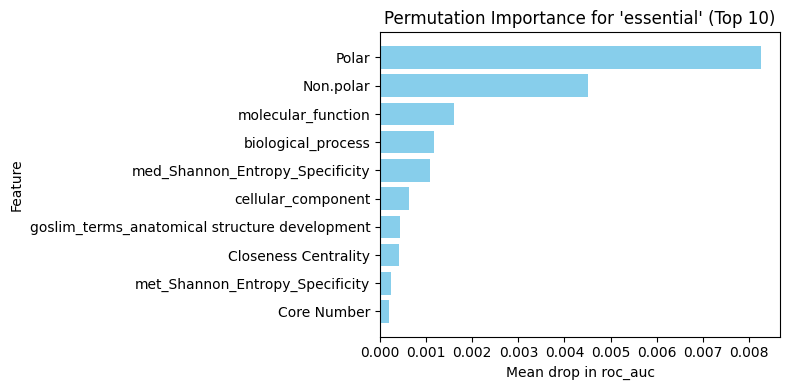

In [ ]:
# use the function
per_label_importances = per_label_perm_importance(
    multi_label_pipeline.named_steps['ovr'],  # the fitted OVR classifier
    X_sel_test,
    y_test,      # DataFrame with columns ['lethal','sterile','dominant','recessive','essential']
    feature_names,
    top_n=10,
    scoring='roc_auc'  # you can also use 'f1' or 'accuracy'
)

# per_label_importances['lethal'] is a DataFrame of 84 rows sorted by importance for lethal vs. not.

In [ ]:
per_label_importances['lethal']

,feature,importance
0,Polar,0.010585
1,Non.polar,0.006133
2,biological_process,0.002552
3,molecular_function,0.001723
4,med_Shannon_Entropy_Specificity,0.001265
...,...,...
95,met_tissue_with_max_expression_mE_mRNA_A_VirF_...,-0.000080
96,med_max_expression,-0.000088
97,fa_median_expression,-0.000136
98,med_mean_expression,-0.000136


# **MultiLabel LR and Feature Importances**

In [ ]:
base_lr = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),   # Logistic regression needs scaled features
    ('lr', LogisticRegression(
        class_weight='balanced',
        max_iter=1000,  # Increase max_iter for convergence
        random_state=42,
        solver='lbfgs',
        n_jobs=-1
    ))
])
ovr_clf = OneVsRestClassifier(base_lr, n_jobs=-1)

#  Create a “wrapper” pipeline that does feature selection before OVR ─────
multi_label_pipeline = Pipeline([
    ('preprocessing', preprocessor),   # transforms X into a dense array
    ('variance',      VarianceThreshold(threshold=0.01)),
    ('select_kbest',  ml_kbest),
    ('select_model',  ml_selmodel),
    ('ovr',           ovr_clf)
], verbose = True)

In [ ]:
# ==============================================================================
# STEP I: Now run a 5-fold Multilabel-Stratified CV using the full pipeline
# ==============================================================================

#  Create a “wrapper” pipeline that does feature selection before OVR ─────
multi_label_pipeline = Pipeline([
    ('preprocessing', preprocessor),   # transforms X into a dense array
    ('variance',      VarianceThreshold(threshold=0.01)),
    ('select_kbest',  ml_kbest),
    ('select_model',  ml_selmodel),
    ('ovr',           ovr_clf)
], verbose = True)

mlskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []
fold_reports = []

for fold, (train_idx, test_idx) in enumerate(mlskf.split(X, y), start=1):
    X_tr, X_te = X.iloc[train_idx].reset_index(drop=True), X.iloc[test_idx].reset_index(drop=True)
    y_tr, y_te = y.iloc[train_idx].reset_index(drop=True), y.iloc[test_idx].reset_index(drop=True)

    print(f"\n--- Fold {fold} ---")
    print("  Train label counts:", y_tr.sum(axis=0).to_dict())
    print("  Test  label counts:", y_te.sum(axis=0).to_dict())

    # Fit on this fold’s training data
    multi_label_pipeline.fit(X_tr, y_tr.values)

    # Predict on this fold’s test data (no SMOTE on test)
    y_pred = multi_label_pipeline.predict(X_te)

    # Compute subset‐accuracy
    acc = accuracy_score(y_te.values, y_pred)
    fold_accuracies.append(acc)

    print(f"  Fold {fold} subset‐accuracy: {acc:.4f}")
    print("  Classification report (test):")
    report = classification_report(
        y_te.values,
        y_pred,
        target_names=label_cols,
        zero_division=0
    )
    print(report)
    fold_reports.append(report)

# Summarize CV
mean_acc = np.mean(fold_accuracies)
std_acc  = np.std(fold_accuracies)
print(f"\n===== 5-Fold Multilabel-Stratified CV Results =====")
print(f"Mean subset-accuracy: {mean_acc:.4f} ± {std_acc:.4f}")



--- Fold 1 ---
  Train label counts: {'lethal': 1540, 'sterile': 331, 'dominant': 42, 'recessive': 1657, 'essential': 1661}
  Test  label counts: {'lethal': 383, 'sterile': 82, 'dominant': 10, 'recessive': 414, 'essential': 415}
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.3s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.2s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   6.2s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=  10.0s
[Pipeline] ............... (step 5 of 5) Processing ovr, total=   0.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['nitrogen cycle metabolic process'] will be ignored
  warnings.warn(


  Fold 1 subset‐accuracy: 0.5402
  Classification report (test):
              precision    recall  f1-score   support

      lethal       0.60      0.73      0.66       383
     sterile       0.22      0.74      0.34        82
    dominant       0.04      0.40      0.07        10
   recessive       0.61      0.71      0.66       414
   essential       0.61      0.70      0.65       415

   micro avg       0.51      0.71      0.60      1304
   macro avg       0.42      0.66      0.47      1304
weighted avg       0.58      0.71      0.63      1304
 samples avg       0.24      0.25      0.24      1304


--- Fold 2 ---
  Train label counts: {'lethal': 1532, 'sterile': 330, 'dominant': 42, 'recessive': 1657, 'essential': 1661}
  Test  label counts: {'lethal': 391, 'sterile': 83, 'dominant': 10, 'recessive': 414, 'essential': 415}
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.0s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.3s
[Pipeline] ...... (s

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['toxin activity'] will be ignored
  warnings.warn(


  Fold 3 subset‐accuracy: 0.5240
  Classification report (test):
              precision    recall  f1-score   support

      lethal       0.58      0.72      0.64       385
     sterile       0.20      0.66      0.30        82
    dominant       0.06      0.55      0.10        11
   recessive       0.62      0.72      0.67       414
   essential       0.61      0.71      0.66       415

   micro avg       0.51      0.71      0.60      1307
   macro avg       0.41      0.67      0.48      1307
weighted avg       0.58      0.71      0.63      1307
 samples avg       0.24      0.25      0.24      1307


--- Fold 4 ---
  Train label counts: {'lethal': 1540, 'sterile': 330, 'dominant': 41, 'recessive': 1656, 'essential': 1661}
  Test  label counts: {'lethal': 383, 'sterile': 83, 'dominant': 11, 'recessive': 415, 'essential': 415}
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.1s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.4s
[Pipeline] ...... (s

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['inflammatory response'] will be ignored
  warnings.warn(


  Fold 4 subset‐accuracy: 0.5321
  Classification report (test):
              precision    recall  f1-score   support

      lethal       0.61      0.73      0.67       383
     sterile       0.19      0.66      0.30        83
    dominant       0.06      0.55      0.10        11
   recessive       0.64      0.71      0.67       415
   essential       0.64      0.69      0.67       415

   micro avg       0.53      0.71      0.60      1307
   macro avg       0.43      0.67      0.48      1307
weighted avg       0.60      0.71      0.64      1307
 samples avg       0.24      0.25      0.24      1307


--- Fold 5 ---
  Train label counts: {'lethal': 1542, 'sterile': 330, 'dominant': 42, 'recessive': 1657, 'essential': 1660}
  Test  label counts: {'lethal': 381, 'sterile': 83, 'dominant': 10, 'recessive': 414, 'essential': 416}
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.1s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.2s
[Pipeline] ...... (s

In [ ]:
# Extracting the reduced feature set
# Step through the same transforms **up to** but not including 'ovr'
pre       = multi_label_pipeline.named_steps['preprocessing']
var       = multi_label_pipeline.named_steps['variance']
kbest     = multi_label_pipeline.named_steps['select_kbest']
selmodel  = multi_label_pipeline.named_steps['select_model']

# For training set (so SHAP or permutation sees the same distribution the model was trained on)
X_pre_train = pre.transform(X_train)      # → shape (n_train, n_after_preproc)
X_var_train = var.transform(X_pre_train)  # → shape (n_train, n_after_variance)
X_kb_train  = kbest.transform(X_var_train) # → shape (n_train, 500)
X_sel_train = selmodel.transform(X_kb_train) # → shape (n_train, n_selected ≈ 84)

# For test set
X_pre_test = pre.transform(X_test)
X_var_test = var.transform(X_pre_test)
X_kb_test  = kbest.transform(X_var_test)
X_sel_test = selmodel.transform(X_kb_test)  # → shape (n_test, n_selected ≈ 84)


In [ ]:
feature_names = get_selected_feature_names(
    multi_label_pipeline,
    numerical_cols,
    onehot_cols,
    multilabel_transformer
)
# feature_names is a list of length ≈84 in the exact order of X_sel_train’s columns
lr_feature_names = feature_names

In [ ]:
lr_feature_names = feature_names

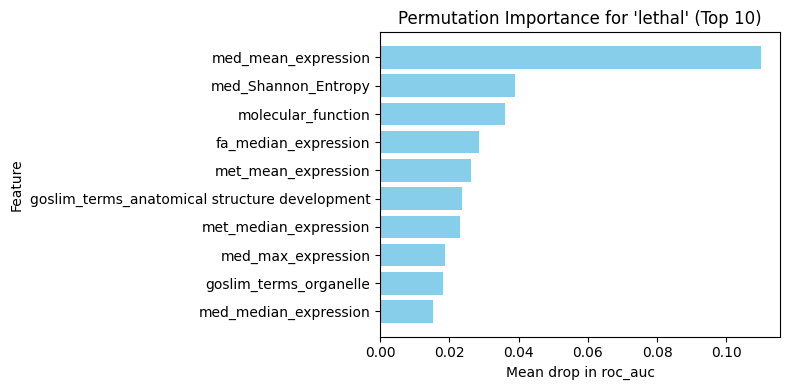

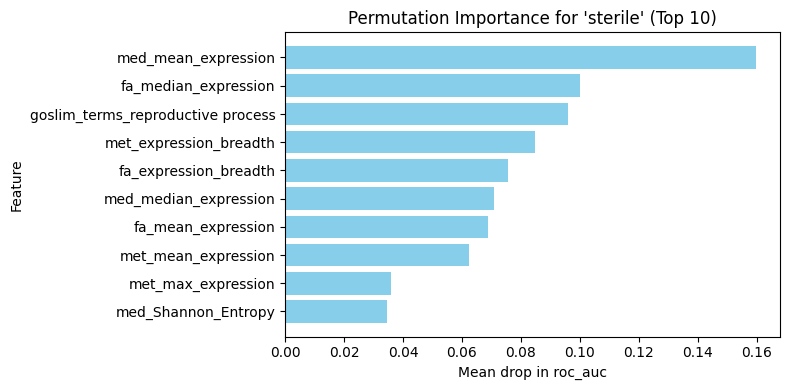

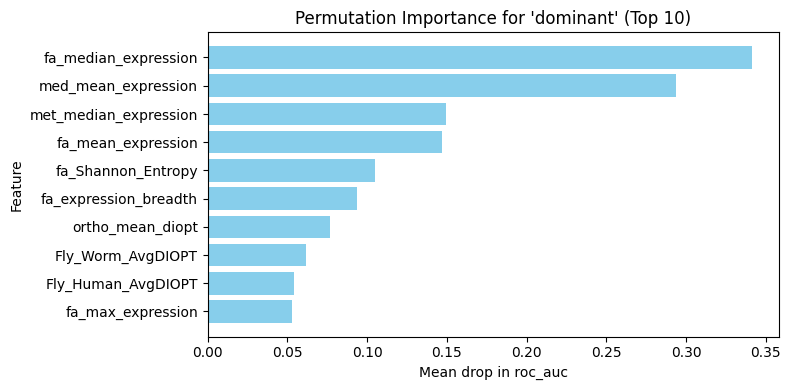

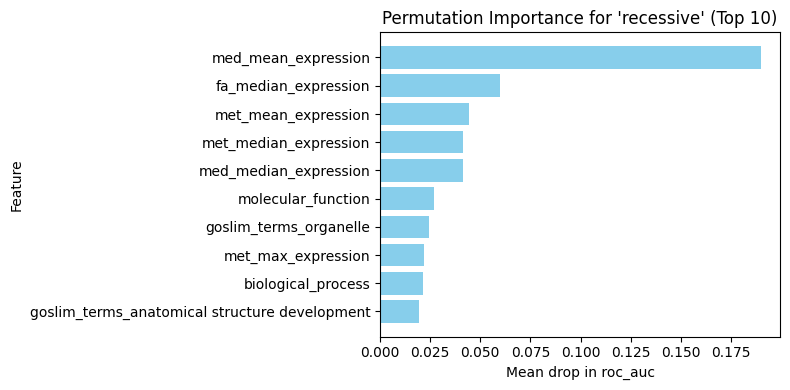

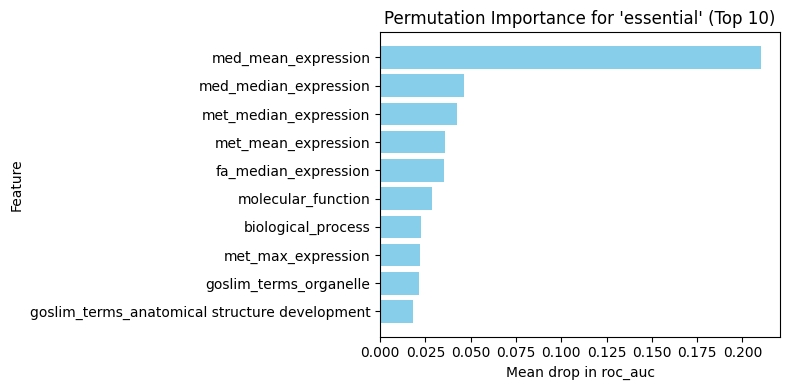

In [ ]:
# use the function
lr_per_label_importances = per_label_perm_importance(
    multi_label_pipeline.named_steps['ovr'],  # the fitted OVR classifier
    X_sel_test,
    y_test,      # DataFrame with columns ['lethal','sterile','dominant','recessive','essential']
    feature_names,
    top_n=10,
    scoring='roc_auc'  # you can also use 'f1' or 'accuracy'
)

# per_label_importances['lethal'] is a DataFrame of 84 rows sorted by importance for lethal vs. not.

# **SVM Multilabel Classification and Features**

In [ ]:
base_svm = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('svm',    SVC(kernel = 'rbf', class_weight = 'balanced',probability = True, random_state = 42))
])

ovr_clf = OneVsRestClassifier(base_svm, n_jobs=-1)

In [ ]:
# ==============================================================================
# STEP I: Now run a 5-fold Multilabel-Stratified CV using the full pipeline
# ==============================================================================

#  Create a “wrapper” pipeline that does feature selection before OVR ─────
multi_label_pipeline = Pipeline([
    ('preprocessing', preprocessor),   # transforms X into a dense array
    ('variance',      VarianceThreshold(threshold=0.01)),
    ('select_kbest',  ml_kbest),
    ('select_model',  ml_selmodel),
    ('ovr',           ovr_clf)
], verbose = True)

mlskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []
fold_reports = []

for fold, (train_idx, test_idx) in enumerate(mlskf.split(X, y), start=1):
    X_tr, X_te = X.iloc[train_idx].reset_index(drop=True), X.iloc[test_idx].reset_index(drop=True)
    y_tr, y_te = y.iloc[train_idx].reset_index(drop=True), y.iloc[test_idx].reset_index(drop=True)

    print(f"\n--- Fold {fold} ---")
    print("  Train label counts:", y_tr.sum(axis=0).to_dict())
    print("  Test  label counts:", y_te.sum(axis=0).to_dict())

    # Fit on this fold’s training data
    multi_label_pipeline.fit(X_tr, y_tr.values)

    # Predict on this fold’s test data (no SMOTE on test)
    y_pred = multi_label_pipeline.predict(X_te)

    # Compute subset‐accuracy
    acc = accuracy_score(y_te.values, y_pred)
    fold_accuracies.append(acc)

    print(f"  Fold {fold} subset‐accuracy: {acc:.4f}")
    print("  Classification report (test):")
    report = classification_report(
        y_te.values,
        y_pred,
        target_names=label_cols,
        zero_division=0
    )
    print(report)
    fold_reports.append(report)

# Summarize CV
mean_acc = np.mean(fold_accuracies)
std_acc  = np.std(fold_accuracies)
print(f"\n===== 5-Fold Multilabel-Stratified CV Results =====")
print(f"Mean subset-accuracy: {mean_acc:.4f} ± {std_acc:.4f}")



--- Fold 1 ---
  Train label counts: {'lethal': 1540, 'sterile': 331, 'dominant': 42, 'recessive': 1657, 'essential': 1661}
  Test  label counts: {'lethal': 383, 'sterile': 82, 'dominant': 10, 'recessive': 414, 'essential': 415}
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.8s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.1s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   4.6s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=  11.7s
[Pipeline] ............... (step 5 of 5) Processing ovr, total= 1.0min


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['nitrogen cycle metabolic process'] will be ignored
  warnings.warn(


  Fold 1 subset‐accuracy: 0.6952
  Classification report (test):
              precision    recall  f1-score   support

      lethal       0.70      0.72      0.71       383
     sterile       0.27      0.34      0.30        82
    dominant       0.00      0.00      0.00        10
   recessive       0.73      0.73      0.73       414
   essential       0.73      0.71      0.72       415

   micro avg       0.68      0.69      0.69      1304
   macro avg       0.49      0.50      0.49      1304
weighted avg       0.69      0.69      0.69      1304
 samples avg       0.26      0.25      0.25      1304


--- Fold 2 ---
  Train label counts: {'lethal': 1532, 'sterile': 330, 'dominant': 42, 'recessive': 1657, 'essential': 1661}
  Test  label counts: {'lethal': 391, 'sterile': 83, 'dominant': 10, 'recessive': 414, 'essential': 415}
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.6s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.0s
[Pipeline] ...... (s

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['toxin activity'] will be ignored
  warnings.warn(


  Fold 3 subset‐accuracy: 0.6515
  Classification report (test):
              precision    recall  f1-score   support

      lethal       0.63      0.71      0.67       385
     sterile       0.27      0.38      0.32        82
    dominant       0.20      0.09      0.12        11
   recessive       0.70      0.74      0.72       414
   essential       0.68      0.73      0.70       415

   micro avg       0.64      0.70      0.67      1307
   macro avg       0.50      0.53      0.51      1307
weighted avg       0.64      0.70      0.67      1307
 samples avg       0.26      0.25      0.25      1307


--- Fold 4 ---
  Train label counts: {'lethal': 1540, 'sterile': 330, 'dominant': 41, 'recessive': 1656, 'essential': 1661}
  Test  label counts: {'lethal': 383, 'sterile': 83, 'dominant': 11, 'recessive': 415, 'essential': 415}
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.0s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.0s
[Pipeline] ...... (s

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['inflammatory response'] will be ignored
  warnings.warn(


  Fold 4 subset‐accuracy: 0.6932
  Classification report (test):
              precision    recall  f1-score   support

      lethal       0.69      0.78      0.73       383
     sterile       0.22      0.34      0.27        83
    dominant       0.00      0.00      0.00        11
   recessive       0.74      0.76      0.75       415
   essential       0.73      0.77      0.75       415

   micro avg       0.67      0.73      0.70      1307
   macro avg       0.48      0.53      0.50      1307
weighted avg       0.68      0.73      0.71      1307
 samples avg       0.27      0.26      0.26      1307


--- Fold 5 ---
  Train label counts: {'lethal': 1542, 'sterile': 330, 'dominant': 42, 'recessive': 1657, 'essential': 1660}
  Test  label counts: {'lethal': 381, 'sterile': 83, 'dominant': 10, 'recessive': 414, 'essential': 416}
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.5s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.0s
[Pipeline] ...... (s

In [ ]:
# Extracting the reduced feature set
# Step through the same transforms **up to** but not including 'ovr'
pre       = multi_label_pipeline.named_steps['preprocessing']
var       = multi_label_pipeline.named_steps['variance']
kbest     = multi_label_pipeline.named_steps['select_kbest']
selmodel  = multi_label_pipeline.named_steps['select_model']

# For training set (so SHAP or permutation sees the same distribution the model was trained on)
X_pre_train = pre.transform(X_train)      # → shape (n_train, n_after_preproc)
X_var_train = var.transform(X_pre_train)  # → shape (n_train, n_after_variance)
X_kb_train  = kbest.transform(X_var_train) # → shape (n_train, 500)
X_sel_train = selmodel.transform(X_kb_train) # → shape (n_train, n_selected ≈ 84)

# For test set
X_pre_test = pre.transform(X_test)
X_var_test = var.transform(X_pre_test)
X_kb_test  = kbest.transform(X_var_test)
X_sel_test = selmodel.transform(X_kb_test)  # → shape (n_test, n_selected ≈ 84)


In [ ]:
feature_names = get_selected_feature_names(
    multi_label_pipeline,
    numerical_cols,
    onehot_cols,
    multilabel_transformer
)
# feature_names is a list of length ≈84 in the exact order of X_sel_train’s columns
svm_feature_names = feature_names

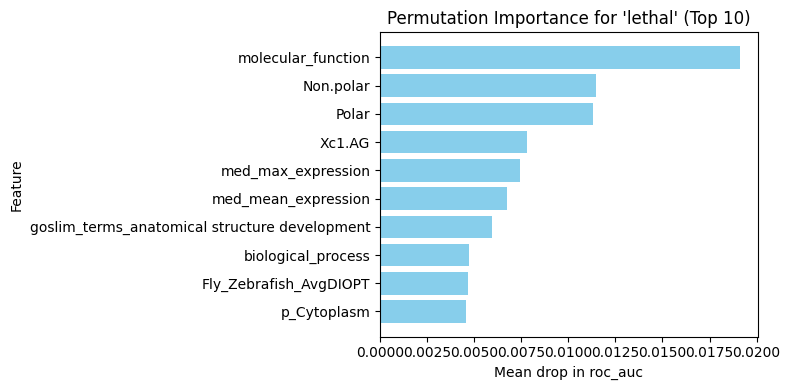

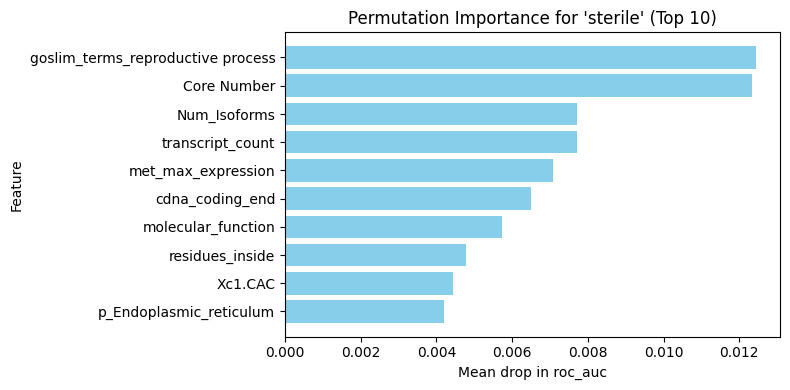

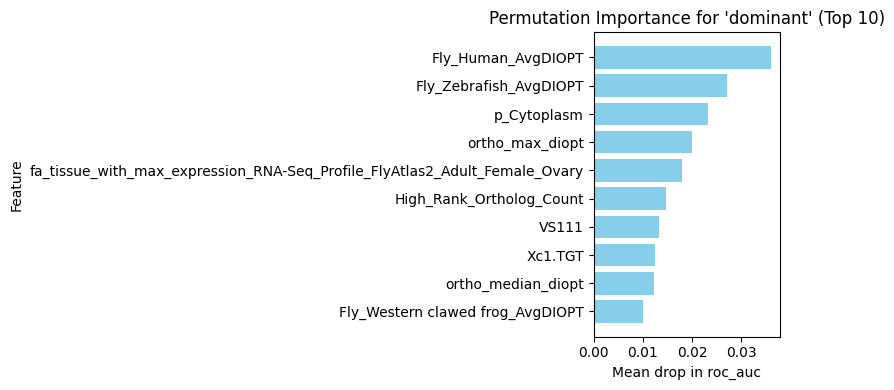

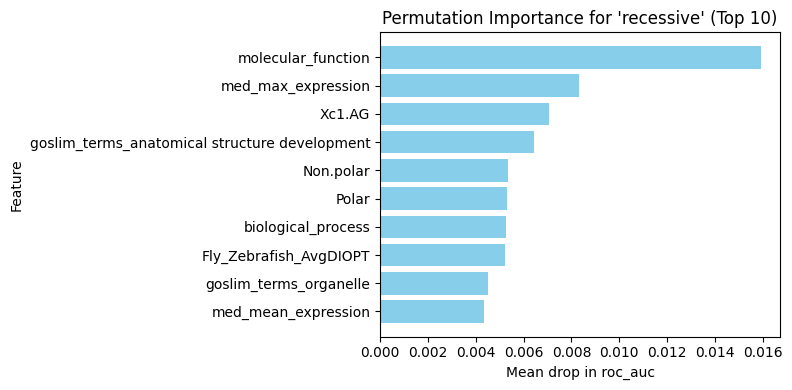

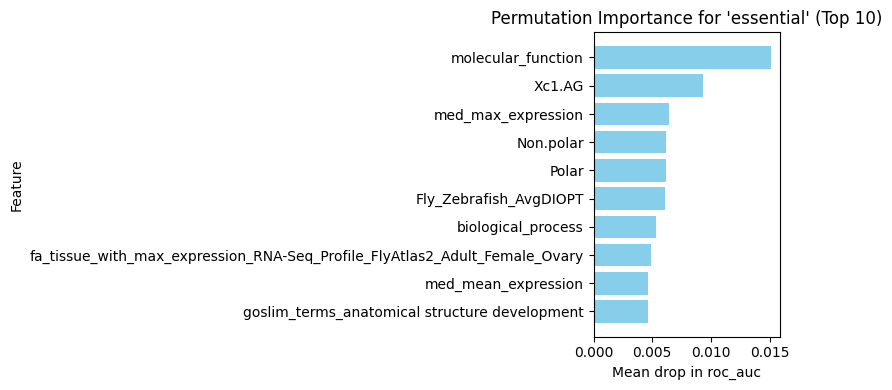

In [ ]:
# use the function
per_label_importances = per_label_perm_importance(
    multi_label_pipeline.named_steps['ovr'],  # the fitted OVR classifier
    X_sel_test,
    y_test,      # DataFrame with columns ['lethal','sterile','dominant','recessive','essential']
    feature_names,
    top_n=10,
    scoring='roc_auc'  # you can also use 'f1' or 'accuracy'
)

# per_label_importances['lethal'] is a DataFrame of 84 rows sorted by importance for lethal vs. not.
svm_per_label_importances = per_label_importances

# **GBM Multilabel Classification and Per-Label Features**

In [ ]:
base_gbm = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('gbm',    GradientBoostingClassifier(n_estimators = 100, loss = 'log_loss', random_state = 42))
])

ovr_clf = OneVsRestClassifier(base_gbm, n_jobs=-1)

In [ ]:
# ==============================================================================
# STEP I: Now run a 5-fold Multilabel-Stratified CV using the full pipeline
# ==============================================================================

#  Create a “wrapper” pipeline that does feature selection before OVR ─────
multi_label_pipeline = Pipeline([
    ('preprocessing', preprocessor),   # transforms X into a dense array
    ('variance',      VarianceThreshold(threshold=0.01)),
    ('select_kbest',  ml_kbest),
    ('select_model',  ml_selmodel),
    ('ovr',           ovr_clf)
], verbose = True)

mlskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []
fold_reports = []

for fold, (train_idx, test_idx) in enumerate(mlskf.split(X, y), start=1):
    X_tr, X_te = X.iloc[train_idx].reset_index(drop=True), X.iloc[test_idx].reset_index(drop=True)
    y_tr, y_te = y.iloc[train_idx].reset_index(drop=True), y.iloc[test_idx].reset_index(drop=True)

    print(f"\n--- Fold {fold} ---")
    print("  Train label counts:", y_tr.sum(axis=0).to_dict())
    print("  Test  label counts:", y_te.sum(axis=0).to_dict())

    # Fit on this fold’s training data
    multi_label_pipeline.fit(X_tr, y_tr.values)

    # Predict on this fold’s test data (no SMOTE on test)
    y_pred = multi_label_pipeline.predict(X_te)

    # Compute subset‐accuracy
    acc = accuracy_score(y_te.values, y_pred)
    fold_accuracies.append(acc)

    print(f"  Fold {fold} subset‐accuracy: {acc:.4f}")
    print("  Classification report (test):")
    report = classification_report(
        y_te.values,
        y_pred,
        target_names=label_cols,
        zero_division=0
    )
    print(report)
    fold_reports.append(report)

# Summarize CV
mean_acc = np.mean(fold_accuracies)
std_acc  = np.std(fold_accuracies)
print(f"\n===== 5-Fold Multilabel-Stratified CV Results =====")
print(f"Mean subset-accuracy: {mean_acc:.4f} ± {std_acc:.4f}")



--- Fold 1 ---
  Train label counts: {'lethal': 1540, 'sterile': 331, 'dominant': 42, 'recessive': 1657, 'essential': 1661}
  Test  label counts: {'lethal': 383, 'sterile': 82, 'dominant': 10, 'recessive': 414, 'essential': 415}
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.9s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.4s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   4.5s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   8.3s
[Pipeline] ............... (step 5 of 5) Processing ovr, total= 1.4min


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['nitrogen cycle metabolic process'] will be ignored
  warnings.warn(


  Fold 1 subset‐accuracy: 0.7868
  Classification report (test):
              precision    recall  f1-score   support

      lethal       0.78      0.90      0.83       383
     sterile       0.46      0.29      0.36        82
    dominant       0.40      0.20      0.27        10
   recessive       0.80      0.89      0.84       414
   essential       0.80      0.89      0.84       415

   micro avg       0.78      0.85      0.81      1304
   macro avg       0.65      0.63      0.63      1304
weighted avg       0.77      0.85      0.80      1304
 samples avg       0.32      0.30      0.31      1304


--- Fold 2 ---
  Train label counts: {'lethal': 1532, 'sterile': 330, 'dominant': 42, 'recessive': 1657, 'essential': 1661}
  Test  label counts: {'lethal': 391, 'sterile': 83, 'dominant': 10, 'recessive': 414, 'essential': 415}
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.6s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   2.0s
[Pipeline] ...... (s

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['toxin activity'] will be ignored
  warnings.warn(


  Fold 3 subset‐accuracy: 0.7680
  Classification report (test):
              precision    recall  f1-score   support

      lethal       0.74      0.90      0.81       385
     sterile       0.40      0.21      0.27        82
    dominant       0.50      0.09      0.15        11
   recessive       0.77      0.90      0.83       414
   essential       0.77      0.90      0.83       415

   micro avg       0.75      0.85      0.80      1307
   macro avg       0.64      0.60      0.58      1307
weighted avg       0.74      0.85      0.78      1307
 samples avg       0.32      0.30      0.31      1307


--- Fold 4 ---
  Train label counts: {'lethal': 1540, 'sterile': 330, 'dominant': 41, 'recessive': 1656, 'essential': 1661}
  Test  label counts: {'lethal': 383, 'sterile': 83, 'dominant': 11, 'recessive': 415, 'essential': 415}
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.9s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.3s
[Pipeline] ...... (s

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['inflammatory response'] will be ignored
  warnings.warn(


  Fold 4 subset‐accuracy: 0.7712
  Classification report (test):
              precision    recall  f1-score   support

      lethal       0.75      0.92      0.83       383
     sterile       0.37      0.28      0.32        83
    dominant       0.00      0.00      0.00        11
   recessive       0.78      0.91      0.84       415
   essential       0.77      0.91      0.84       415

   micro avg       0.75      0.87      0.80      1307
   macro avg       0.53      0.60      0.56      1307
weighted avg       0.74      0.87      0.79      1307
 samples avg       0.33      0.31      0.31      1307


--- Fold 5 ---
  Train label counts: {'lethal': 1542, 'sterile': 330, 'dominant': 42, 'recessive': 1657, 'essential': 1660}
  Test  label counts: {'lethal': 381, 'sterile': 83, 'dominant': 10, 'recessive': 414, 'essential': 416}
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.6s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.2s
[Pipeline] ...... (s

In [ ]:
# Extracting the reduced feature set
# Step through the same transforms **up to** but not including 'ovr'
pre       = multi_label_pipeline.named_steps['preprocessing']
var       = multi_label_pipeline.named_steps['variance']
kbest     = multi_label_pipeline.named_steps['select_kbest']
selmodel  = multi_label_pipeline.named_steps['select_model']

# For training set (so SHAP or permutation sees the same distribution the model was trained on)
X_pre_train = pre.transform(X_train)      # → shape (n_train, n_after_preproc)
X_var_train = var.transform(X_pre_train)  # → shape (n_train, n_after_variance)
X_kb_train  = kbest.transform(X_var_train) # → shape (n_train, 500)
X_sel_train = selmodel.transform(X_kb_train) # → shape (n_train, n_selected ≈ 84)

# For test set
X_pre_test = pre.transform(X_test)
X_var_test = var.transform(X_pre_test)
X_kb_test  = kbest.transform(X_var_test)
X_sel_test = selmodel.transform(X_kb_test)  # → shape (n_test, n_selected ≈ 84)


In [ ]:
feature_names = get_selected_feature_names(
    multi_label_pipeline,
    numerical_cols,
    onehot_cols,
    multilabel_transformer
)
# feature_names is a list of length ≈84 in the exact order of X_sel_train’s columns
gbm_feature_names = feature_names

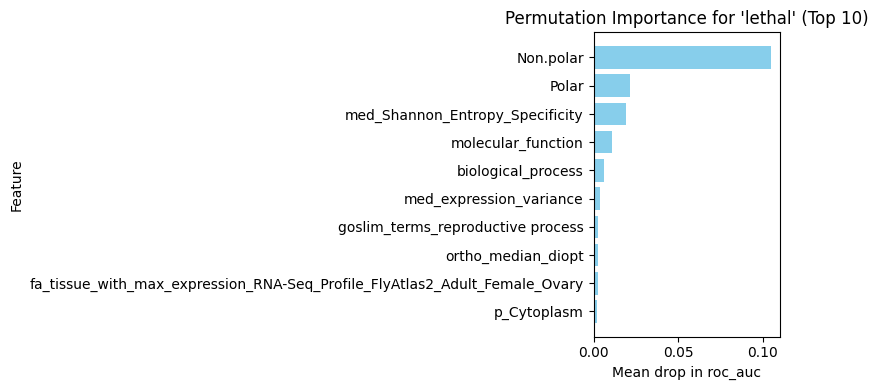

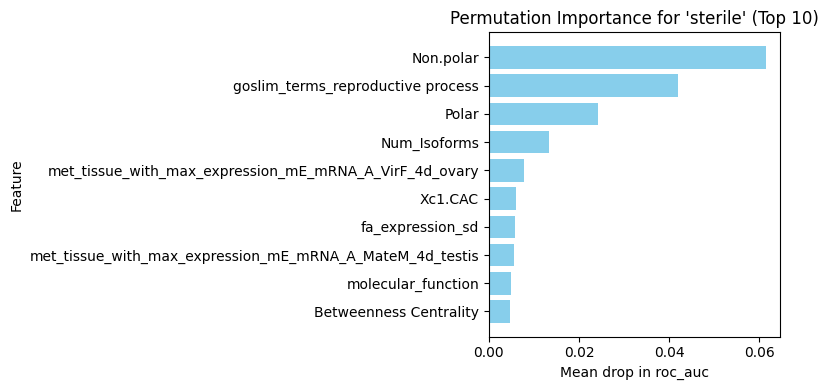

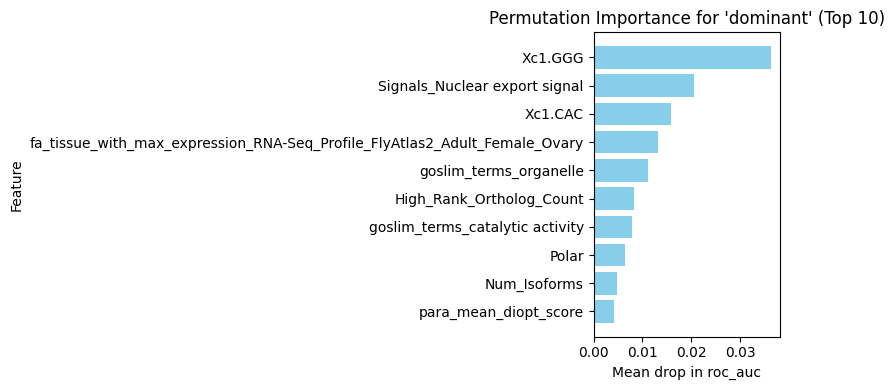

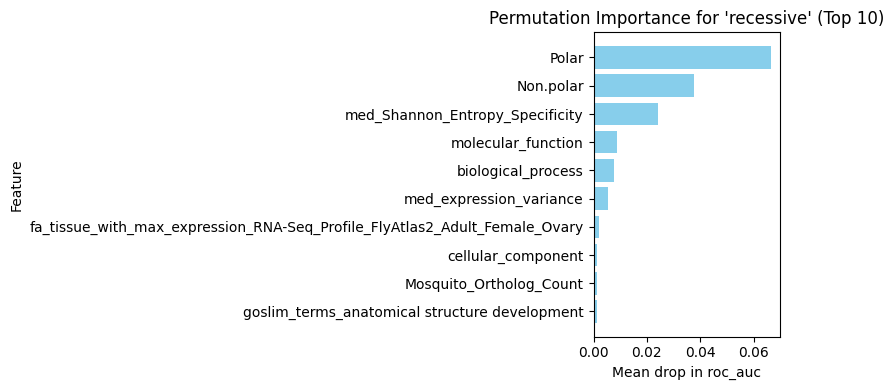

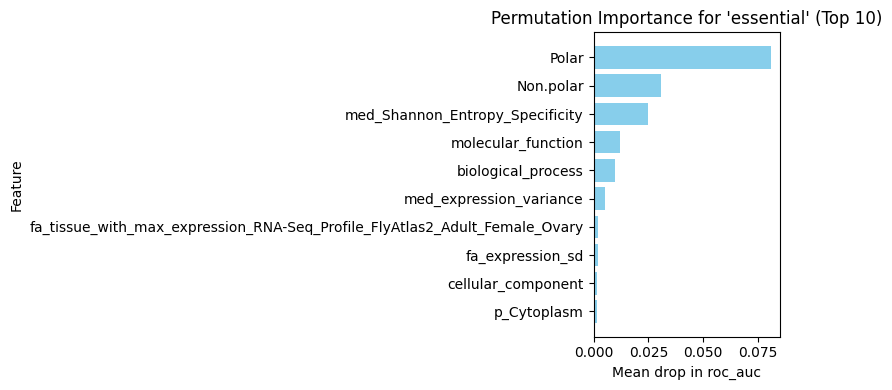

In [ ]:
# use the function
per_label_importances = per_label_perm_importance(
    multi_label_pipeline.named_steps['ovr'],  # the fitted OVR classifier
    X_sel_test,
    y_test,      # DataFrame with columns ['lethal','sterile','dominant','recessive','essential']
    feature_names,
    top_n=10,
    scoring='roc_auc'  # you can also use 'f1' or 'accuracy'
)

# per_label_importances['lethal'] is a DataFrame of 84 rows sorted by importance for lethal vs. not.
gbm_per_label_importances = per_label_importances

# **XGB Multilabel Classification and Per-Label Features**

In [ ]:
base_xgb = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('xgb',    XGBClassifier(n_estimators = 100, eval_metric = 'logloss',
                              scale_pos_weight = 1, random_state = 42))
])

ovr_clf = OneVsRestClassifier(base_xgb, n_jobs=-1)

In [ ]:
# ==============================================================================
# STEP I: Now run a 5-fold Multilabel-Stratified CV using the full pipeline
# ==============================================================================

#  Create a “wrapper” pipeline that does feature selection before OVR ─────
multi_label_pipeline = Pipeline([
    ('preprocessing', preprocessor),   # transforms X into a dense array
    ('variance',      VarianceThreshold(threshold=0.01)),
    ('select_kbest',  ml_kbest),
    ('select_model',  ml_selmodel),
    ('ovr',           ovr_clf)
], verbose = True)

mlskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []
fold_reports = []

for fold, (train_idx, test_idx) in enumerate(mlskf.split(X, y), start=1):
    X_tr, X_te = X.iloc[train_idx].reset_index(drop=True), X.iloc[test_idx].reset_index(drop=True)
    y_tr, y_te = y.iloc[train_idx].reset_index(drop=True), y.iloc[test_idx].reset_index(drop=True)

    print(f"\n--- Fold {fold} ---")
    print("  Train label counts:", y_tr.sum(axis=0).to_dict())
    print("  Test  label counts:", y_te.sum(axis=0).to_dict())

    # Fit on this fold’s training data
    multi_label_pipeline.fit(X_tr, y_tr.values)

    # Predict on this fold’s test data (no SMOTE on test)
    y_pred = multi_label_pipeline.predict(X_te)

    # Compute subset‐accuracy
    acc = accuracy_score(y_te.values, y_pred)
    fold_accuracies.append(acc)

    print(f"  Fold {fold} subset‐accuracy: {acc:.4f}")
    print("  Classification report (test):")
    report = classification_report(
        y_te.values,
        y_pred,
        target_names=label_cols,
        zero_division=0
    )
    print(report)
    fold_reports.append(report)

# Summarize CV
mean_acc = np.mean(fold_accuracies)
std_acc  = np.std(fold_accuracies)
print(f"\n===== 5-Fold Multilabel-Stratified CV Results =====")
print(f"Mean subset-accuracy: {mean_acc:.4f} ± {std_acc:.4f}")



--- Fold 1 ---
  Train label counts: {'lethal': 1540, 'sterile': 331, 'dominant': 42, 'recessive': 1657, 'essential': 1661}
  Test  label counts: {'lethal': 383, 'sterile': 82, 'dominant': 10, 'recessive': 414, 'essential': 415}
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.8s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.2s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   4.8s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=  10.6s
[Pipeline] ............... (step 5 of 5) Processing ovr, total=   9.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['nitrogen cycle metabolic process'] will be ignored
  warnings.warn(


  Fold 1 subset‐accuracy: 0.7765
  Classification report (test):
              precision    recall  f1-score   support

      lethal       0.81      0.82      0.81       383
     sterile       0.54      0.24      0.34        82
    dominant       0.33      0.10      0.15        10
   recessive       0.83      0.84      0.84       414
   essential       0.84      0.87      0.86       415

   micro avg       0.82      0.80      0.81      1304
   macro avg       0.67      0.57      0.60      1304
weighted avg       0.81      0.80      0.80      1304
 samples avg       0.32      0.29      0.29      1304


--- Fold 2 ---
  Train label counts: {'lethal': 1532, 'sterile': 330, 'dominant': 42, 'recessive': 1657, 'essential': 1661}
  Test  label counts: {'lethal': 391, 'sterile': 83, 'dominant': 10, 'recessive': 414, 'essential': 415}
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.6s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.2s
[Pipeline] ...... (s

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['toxin activity'] will be ignored
  warnings.warn(


  Fold 3 subset‐accuracy: 0.7817
  Classification report (test):
              precision    recall  f1-score   support

      lethal       0.81      0.86      0.83       385
     sterile       0.43      0.12      0.19        82
    dominant       0.00      0.00      0.00        11
   recessive       0.84      0.86      0.85       414
   essential       0.83      0.85      0.84       415

   micro avg       0.82      0.80      0.81      1307
   macro avg       0.58      0.54      0.54      1307
weighted avg       0.80      0.80      0.79      1307
 samples avg       0.32      0.29      0.30      1307


--- Fold 4 ---
  Train label counts: {'lethal': 1540, 'sterile': 330, 'dominant': 41, 'recessive': 1656, 'essential': 1661}
  Test  label counts: {'lethal': 383, 'sterile': 83, 'dominant': 11, 'recessive': 415, 'essential': 415}
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.3s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.3s
[Pipeline] ...... (s

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['inflammatory response'] will be ignored
  warnings.warn(


  Fold 4 subset‐accuracy: 0.7738
  Classification report (test):
              precision    recall  f1-score   support

      lethal       0.81      0.87      0.84       383
     sterile       0.38      0.18      0.24        83
    dominant       0.00      0.00      0.00        11
   recessive       0.82      0.87      0.84       415
   essential       0.83      0.86      0.85       415

   micro avg       0.80      0.81      0.81      1307
   macro avg       0.57      0.56      0.55      1307
weighted avg       0.78      0.81      0.80      1307
 samples avg       0.32      0.29      0.30      1307


--- Fold 5 ---
  Train label counts: {'lethal': 1542, 'sterile': 330, 'dominant': 42, 'recessive': 1657, 'essential': 1660}
  Test  label counts: {'lethal': 381, 'sterile': 83, 'dominant': 10, 'recessive': 414, 'essential': 416}
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.7s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.3s
[Pipeline] ...... (s

In [ ]:
feature_names = get_selected_feature_names(
    multi_label_pipeline,
    numerical_cols,
    onehot_cols,
    multilabel_transformer
)
# feature_names is a list of length ≈84 in the exact order of X_sel_train’s columns
xgb_feature_names = feature_names

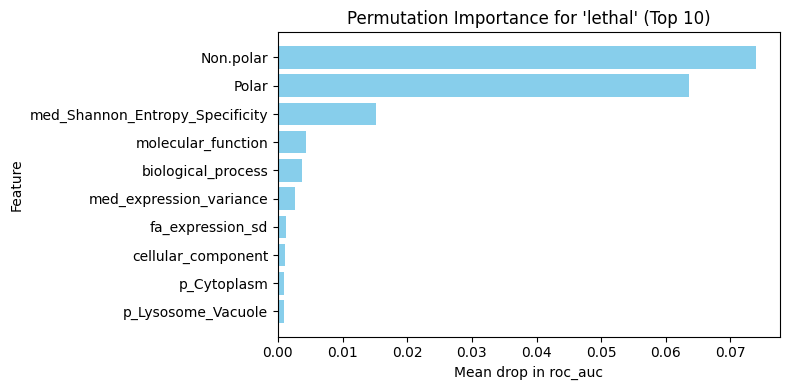

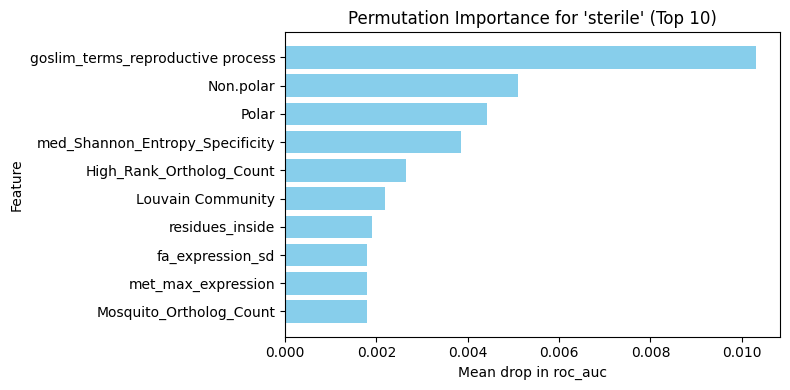

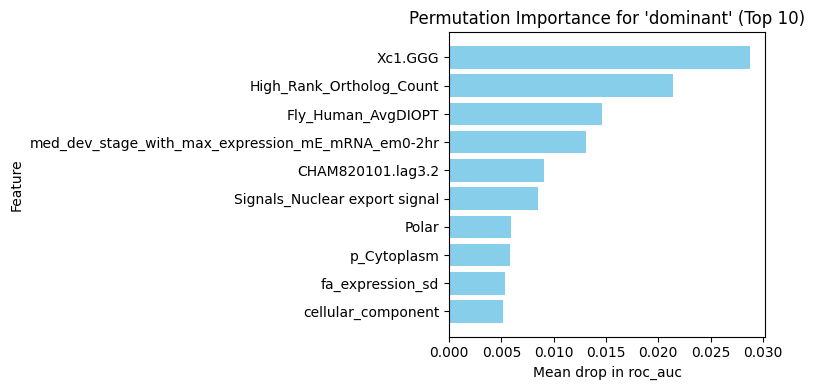

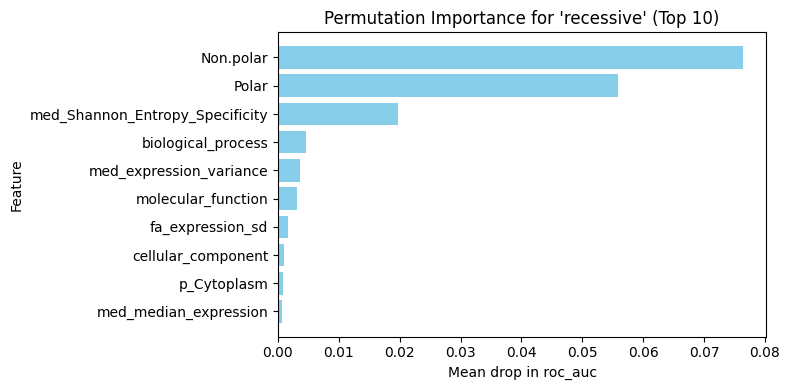

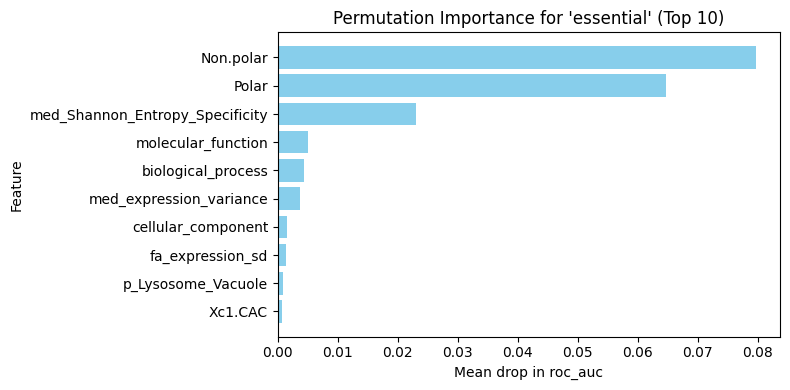

In [ ]:
# use the function
per_label_importances = per_label_perm_importance(
    multi_label_pipeline.named_steps['ovr'],  # the fitted OVR classifier
    X_sel_test,
    y_test,      # DataFrame with columns ['lethal','sterile','dominant','recessive','essential']
    feature_names,
    top_n=10,
    scoring='roc_auc'  # you can also use 'f1' or 'accuracy'
)

# per_label_importances['lethal'] is a DataFrame of 84 rows sorted by importance for lethal vs. not.
xgb_per_label_importances = per_label_importances

# **MLP Multilabel Classification and Per-Label Features**

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(100,),       # Single hidden layer with 100 neurons - a good starting point
        activation='relu',               # ReLU is standard for hidden layers; speeds up training and avoids vanishing gradients
        solver='adam',                   # Adam optimizer handles sparse gradients and noisy data well
        learning_rate='adaptive',       # Adjust learning rate during training if no improvement, helps convergence
        max_iter=300,
        random_state=42,
        early_stopping=True,            # Automatically stops training if validation score doesn't improve to prevent overfitting
        n_iter_no_change=10)

# ==============================================================================
# STEP G: Wrap SMOTE + SVM into a base pipeline, then OneVsRest for multilabel
# ==============================================================================
base_mlp = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('mlp',    mlp)
])

ovr_clf = OneVsRestClassifier(base_mlp, n_jobs=-1)

In [ ]:
# ==============================================================================
# STEP I: Now run a 5-fold Multilabel-Stratified CV using the full pipeline
# ==============================================================================

#  Create a “wrapper” pipeline that does feature selection before OVR ─────
multi_label_pipeline = Pipeline([
    ('preprocessing', preprocessor),   # transforms X into a dense array
    ('variance',      VarianceThreshold(threshold=0.01)),
    ('select_kbest',  ml_kbest),
    ('select_model',  ml_selmodel),
    ('ovr',           ovr_clf)
], verbose = True)

mlskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []
fold_reports = []

for fold, (train_idx, test_idx) in enumerate(mlskf.split(X, y), start=1):
    X_tr, X_te = X.iloc[train_idx].reset_index(drop=True), X.iloc[test_idx].reset_index(drop=True)
    y_tr, y_te = y.iloc[train_idx].reset_index(drop=True), y.iloc[test_idx].reset_index(drop=True)

    print(f"\n--- Fold {fold} ---")
    print("  Train label counts:", y_tr.sum(axis=0).to_dict())
    print("  Test  label counts:", y_te.sum(axis=0).to_dict())

    # Fit on this fold’s training data
    multi_label_pipeline.fit(X_tr, y_tr.values)

    # Predict on this fold’s test data (no SMOTE on test)
    y_pred = multi_label_pipeline.predict(X_te)

    # Compute subset‐accuracy
    acc = accuracy_score(y_te.values, y_pred)
    fold_accuracies.append(acc)

    print(f"  Fold {fold} subset‐accuracy: {acc:.4f}")
    print("  Classification report (test):")
    report = classification_report(
        y_te.values,
        y_pred,
        target_names=label_cols,
        zero_division=0
    )
    print(report)
    fold_reports.append(report)

# Summarize CV
mean_acc = np.mean(fold_accuracies)
std_acc  = np.std(fold_accuracies)
print(f"\n===== 5-Fold Multilabel-Stratified CV Results =====")
print(f"Mean subset-accuracy: {mean_acc:.4f} ± {std_acc:.4f}")



--- Fold 1 ---
  Train label counts: {'lethal': 1540, 'sterile': 331, 'dominant': 42, 'recessive': 1657, 'essential': 1661}
  Test  label counts: {'lethal': 383, 'sterile': 82, 'dominant': 10, 'recessive': 414, 'essential': 415}
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.6s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.2s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   4.6s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   8.2s
[Pipeline] ............... (step 5 of 5) Processing ovr, total=  10.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['nitrogen cycle metabolic process'] will be ignored
  warnings.warn(


  Fold 1 subset‐accuracy: 0.6438
  Classification report (test):
              precision    recall  f1-score   support

      lethal       0.69      0.67      0.68       383
     sterile       0.28      0.27      0.27        82
    dominant       0.12      0.30      0.17        10
   recessive       0.73      0.67      0.70       414
   essential       0.73      0.71      0.72       415

   micro avg       0.68      0.65      0.66      1304
   macro avg       0.51      0.52      0.51      1304
weighted avg       0.68      0.65      0.67      1304
 samples avg       0.25      0.23      0.24      1304


--- Fold 2 ---
  Train label counts: {'lethal': 1532, 'sterile': 330, 'dominant': 42, 'recessive': 1657, 'essential': 1661}
  Test  label counts: {'lethal': 391, 'sterile': 83, 'dominant': 10, 'recessive': 414, 'essential': 415}
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.6s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.2s
[Pipeline] ...... (s

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['toxin activity'] will be ignored
  warnings.warn(


  Fold 3 subset‐accuracy: 0.6293
  Classification report (test):
              precision    recall  f1-score   support

      lethal       0.66      0.69      0.68       385
     sterile       0.22      0.24      0.23        82
    dominant       0.18      0.18      0.18        11
   recessive       0.71      0.75      0.73       414
   essential       0.69      0.71      0.70       415

   micro avg       0.66      0.68      0.67      1307
   macro avg       0.49      0.52      0.50      1307
weighted avg       0.66      0.68      0.67      1307
 samples avg       0.26      0.24      0.25      1307


--- Fold 4 ---
  Train label counts: {'lethal': 1540, 'sterile': 330, 'dominant': 41, 'recessive': 1656, 'essential': 1661}
  Test  label counts: {'lethal': 383, 'sterile': 83, 'dominant': 11, 'recessive': 415, 'essential': 415}
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.7s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.2s
[Pipeline] ...... (s

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['inflammatory response'] will be ignored
  warnings.warn(


  Fold 4 subset‐accuracy: 0.6521
  Classification report (test):
              precision    recall  f1-score   support

      lethal       0.69      0.78      0.73       383
     sterile       0.21      0.25      0.23        83
    dominant       0.00      0.00      0.00        11
   recessive       0.72      0.76      0.74       415
   essential       0.74      0.79      0.76       415

   micro avg       0.67      0.73      0.70      1307
   macro avg       0.47      0.52      0.49      1307
weighted avg       0.68      0.73      0.71      1307
 samples avg       0.29      0.26      0.27      1307


--- Fold 5 ---
  Train label counts: {'lethal': 1542, 'sterile': 330, 'dominant': 42, 'recessive': 1657, 'essential': 1660}
  Test  label counts: {'lethal': 381, 'sterile': 83, 'dominant': 10, 'recessive': 414, 'essential': 416}
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.7s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.2s
[Pipeline] ...... (s

In [ ]:
feature_names = get_selected_feature_names(
    multi_label_pipeline,
    numerical_cols,
    onehot_cols,
    multilabel_transformer
)
# feature_names is a list of length ≈84 in the exact order of X_sel_train’s columns
mlp_feature_names = feature_names

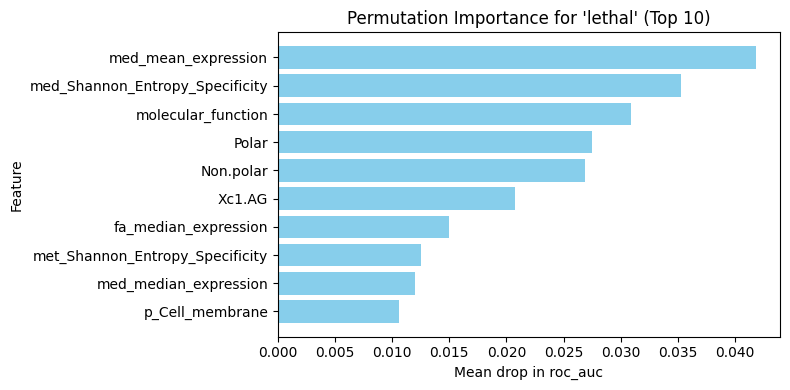

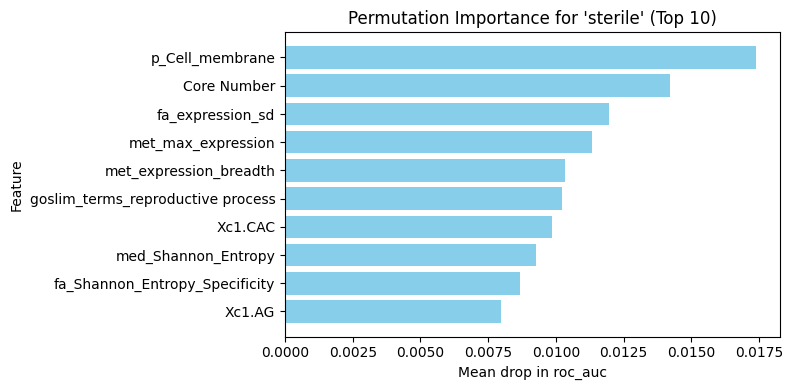

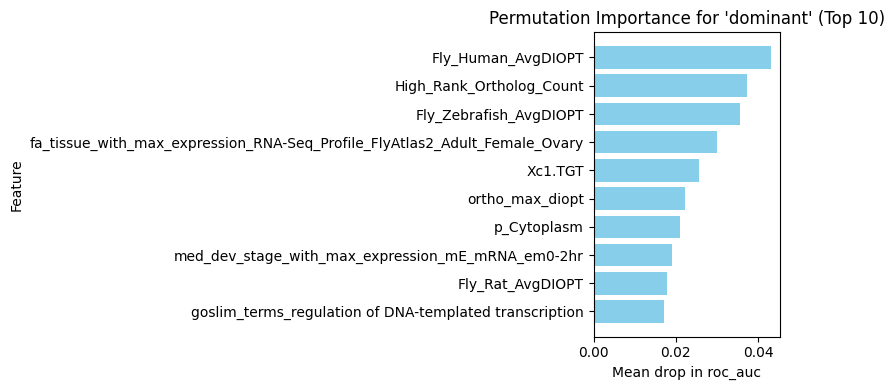

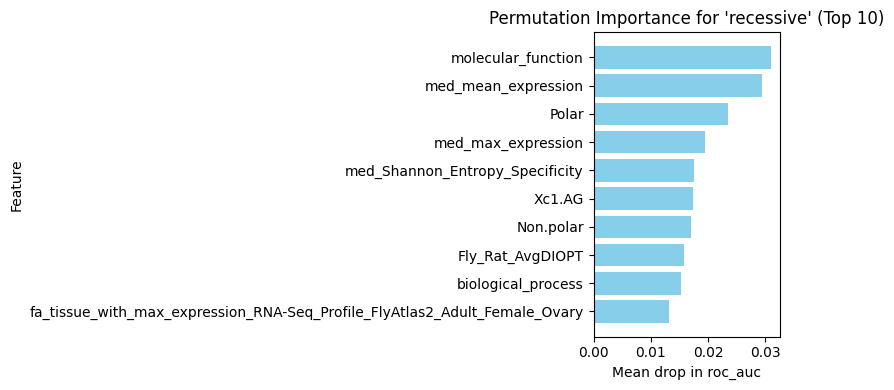

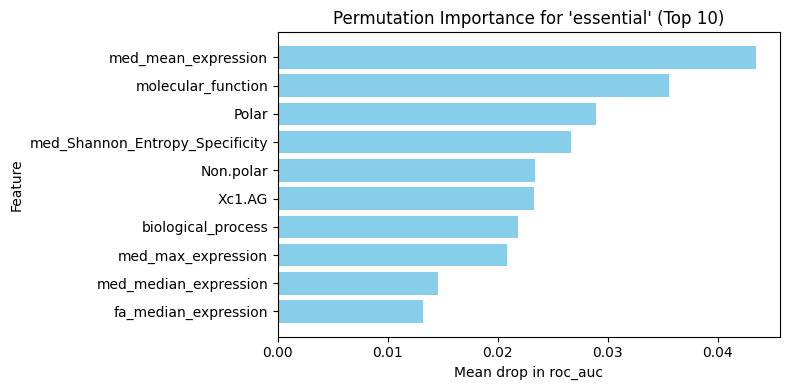

In [ ]:
# use the function
per_label_importances = per_label_perm_importance(
    multi_label_pipeline.named_steps['ovr'],  # the fitted OVR classifier
    X_sel_test,
    y_test,      # DataFrame with columns ['lethal','sterile','dominant','recessive','essential']
    feature_names,
    top_n=10,
    scoring='roc_auc'  # you can also use 'f1' or 'accuracy'
)

# per_label_importances['lethal'] is a DataFrame of 84 rows sorted by importance for lethal vs. not.
mlp_per_label_importances = per_label_importances

# **Comparing classifier feature importances across labels**

In [ ]:
# organise feature importances tables
rf_per_label_importances = per_label_importances
lr_per_label_importances
svm_per_label_importances
gbm_per_label_importances
xgb_per_label_importances
mlp_per_label_importances

{'lethal':                                               feature  importance
 0                                 med_mean_expression    0.041847
 1                     med_Shannon_Entropy_Specificity    0.035297
 2                                  molecular_function    0.030897
 3                                               Polar    0.027530
 4                                           Non.polar    0.026887
 ..                                                ...         ...
 95                              Localizations_Nucleus    0.000468
 96                               goslim_terms_cytosol    0.000430
 97                       Signals_Transmembrane domain    0.000356
 98  fa_tissue_with_max_expression_RNA-Seq_Profile_...    0.000149
 99                           goslim_terms_nucleoplasm   -0.000202
 
 [100 rows x 2 columns],
 'sterile':                                               feature  importance
 0                                     p_Cell_membrane    0.017401
 1            

In [ ]:
# Spearman correlations
# to measure how similarly different classifiers rank all final selected features for a specific phenotype (e.g., "lethal").
# 1.0 - identical rankings between the classifiers, 0.0 no correlation between rankings, -1.0 perfectly reversed rankings between classifiers

from scipy.stats import spearmanr

def compute_spearman_rank_corr(per_label_importances):
    """
    per_label_importances: dict of classifier_name -> DataFrame with columns ['feature', 'importance']
    Returns: Spearman correlation matrix (DataFrame)
    """
    # Step 1: Get a DataFrame of feature ranks per classifier
    feature_ranks = {}
    for clf_name, df in per_label_importances.items():
        df = df.copy()
        df['rank'] = df['importance'].rank(ascending=False, method='min')
        feature_ranks[clf_name] = df.set_index('feature')['rank']

    rank_df = pd.DataFrame(feature_ranks)  # shape: (features x classifiers)

    # Step 2: Compute Spearman correlation matrix between classifiers
    corr_matrix = rank_df.corr(method='spearman')

    # Step 3: Visualize
    sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', fmt=".2f")
    plt.title("Spearman Rank Correlation Between Classifiers")
    plt.show()

    return corr_matrix


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

def compute_jaccard_top_k(per_label_importances, k=20):
    """
    per_label_importances: dict of classifier_name -> DataFrame with columns ['feature', 'importance']
    k: number of top features to consider
    Returns: Jaccard similarity matrix (DataFrame)
    """
    top_k_sets = {}
    all_features = set()

    for clf_name, df in per_label_importances.items():
        top_k = df.nlargest(k, 'importance')['feature']
        top_k_sets[clf_name] = set(top_k)
        all_features.update(top_k)

    classifiers = list(per_label_importances.keys())
    jaccard_matrix = pd.DataFrame(index=classifiers, columns=classifiers, dtype=float)

    for clf1, clf2 in combinations(classifiers, 2):
        set1 = top_k_sets[clf1]
        set2 = top_k_sets[clf2]
        intersection = len(set1 & set2)
        union = len(set1 | set2)
        jaccard = intersection / union if union > 0 else 0.0
        jaccard_matrix.loc[clf1, clf2] = jaccard
        jaccard_matrix.loc[clf2, clf1] = jaccard

    # Diagonal values are 1
    for clf in classifiers:
        jaccard_matrix.loc[clf, clf] = 1.0

    # Visualization
    plt.figure(figsize=(8, 6), dpi = 500)
    ax = sns.heatmap(
        jaccard_matrix.astype(float),
        annot=True,
        fmt=".2f",
        cmap='RdBu_r',
        cbar=True,
        square=True,
        linewidths=0.5,
        linecolor='white',
        annot_kws={"size": 12, "color": "black"}
    )

    # Titles and labels
    ax.set_title(f"Jaccard Similarity of Top-{k} Features Across Classifiers", fontsize=16, weight='bold', color='black', pad=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12, color='black')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12, color='black')
    ax.tick_params(axis='both', colors='black', direction='out', length=5, width=1)

    plt.tight_layout()
    plt.show()

    return jaccard_matrix


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np

def compute_jaccard_top_k(per_label_importances, k=20):
    top_k_sets = {}
    all_features = set()

    for clf_name, df in per_label_importances.items():
        top_k = df.nlargest(k, 'importance')['feature']
        top_k_sets[clf_name] = set(top_k)
        all_features.update(top_k)

    classifiers = list(per_label_importances.keys())
    jaccard_matrix = pd.DataFrame(index=classifiers, columns=classifiers, dtype=float)

    for clf1, clf2 in combinations(classifiers, 2):
        set1, set2 = top_k_sets[clf1], top_k_sets[clf2]
        intersection = len(set1 & set2)
        union = len(set1 | set2)
        jaccard = intersection / union if union > 0 else 0.0
        jaccard_matrix.loc[clf1, clf2] = jaccard
        jaccard_matrix.loc[clf2, clf1] = jaccard

    for clf in classifiers:
        jaccard_matrix.loc[clf, clf] = 1.0

    # Plot
    plt.figure(figsize=(8, 6), dpi=500)
    cmap = sns.diverging_palette(240, 10, as_cmap=True)  # RdBu_r alternative with better control
    mask = np.zeros_like(jaccard_matrix, dtype=bool)  # optional: np.triu mask

    ax = sns.heatmap(
        jaccard_matrix.astype(float),
        annot=True,
        fmt=".2f",
        cmap=cmap,
        square=True,
        linewidths=0.5,
        linecolor='white',
        cbar_kws={'label': 'Jaccard Index'},
        annot_kws={"size": 12},
    )

    # Dynamically adjust text color for visibility
    for text in ax.texts:
        value = float(text.get_text())
        text.set_color("white" if value < 0.4 or value > 0.8 else "black")

    ax.set_title(f"Jaccard Similarity of Top-{k} Features \nAcross Multi-Label Classifiers", fontsize=16, weight='bold', pad=12, color='black')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12, color='black')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12, color='black')
    ax.tick_params(axis='both', colors='black', direction='out', length=5, width=1)

    plt.tight_layout()
    plt.savefig("jaccard_importances.png", dpi=500)
    plt.show()

    return jaccard_matrix


In [ ]:
# analysing 'lethal' features
lethal_importances = {
    'LR': lr_per_label_importances['lethal'],
    'SVM': svm_per_label_importances['lethal'],
    'RF': rf_per_label_importances['lethal'],
    'GBM': gbm_per_label_importances['lethal'],
    'XGB': xgb_per_label_importances['lethal'],
    'MLP': mlp_per_label_importances['lethal'],
}

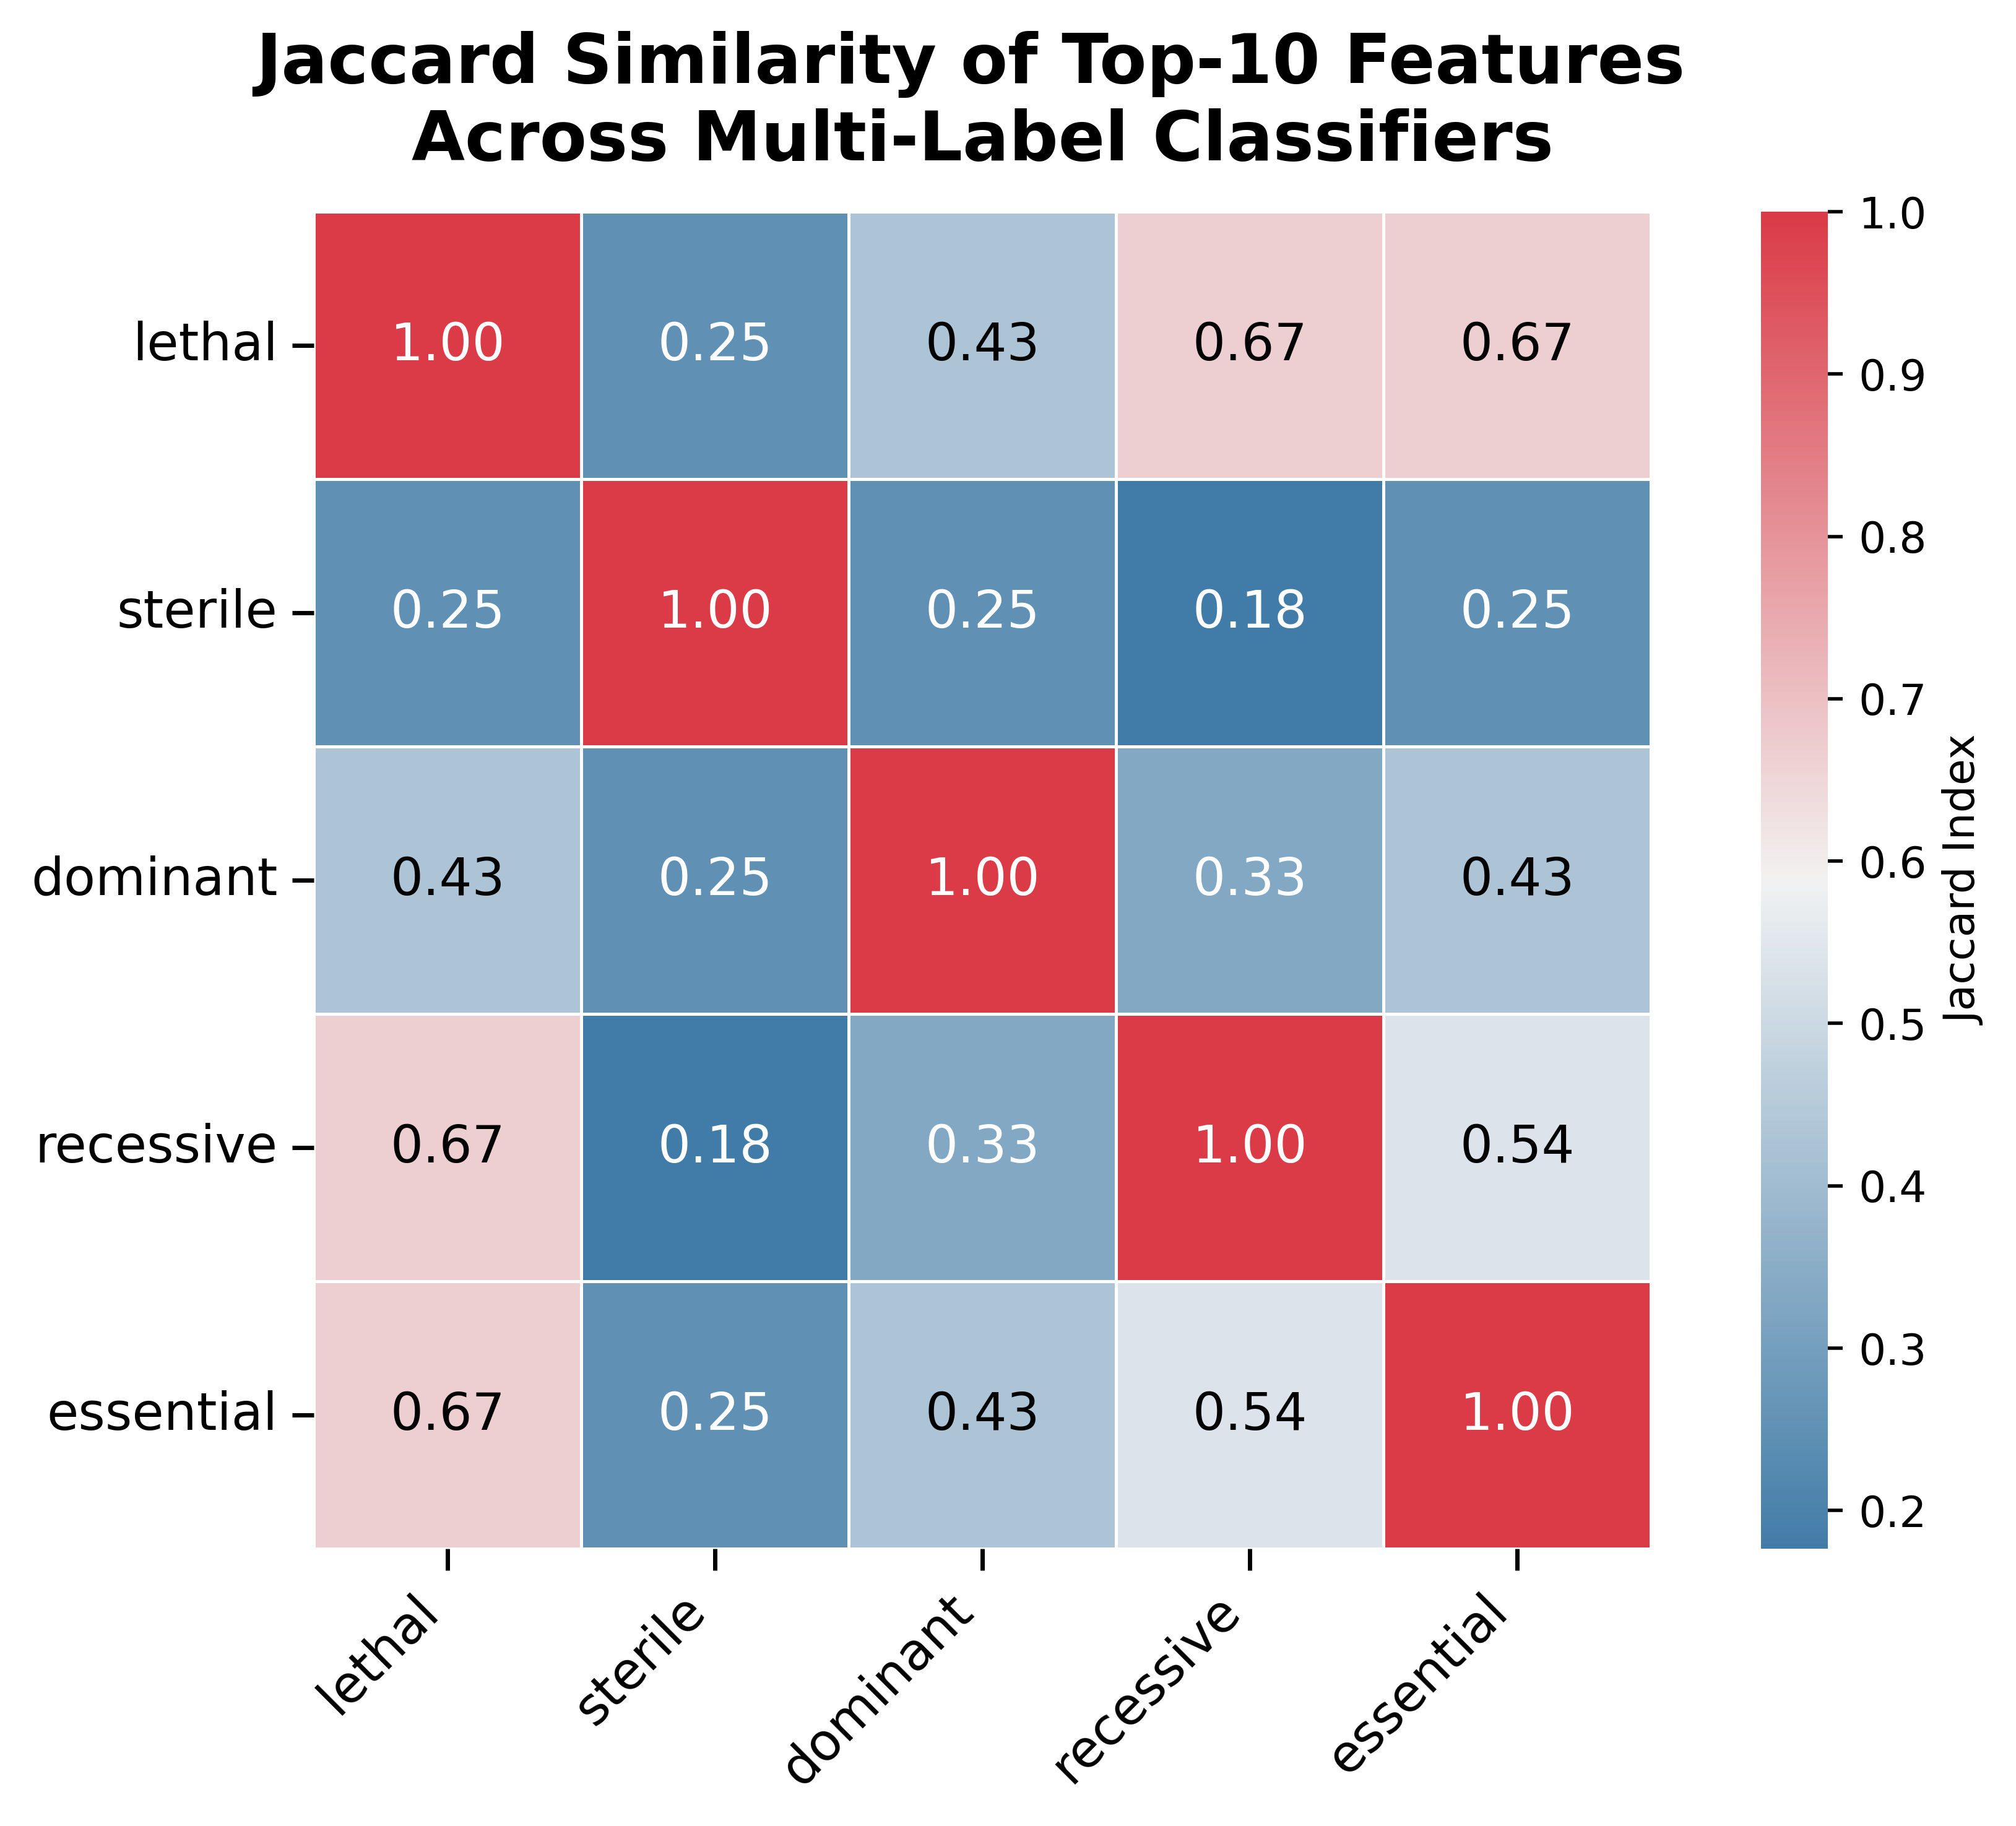

In [ ]:
jaccard_sim = compute_jaccard_top_k(per_label_importances, k=10)

# interpretation: when comparing the top 10 features across classifiers, we see greater overlaps between lethal-essential and lethal-recessive
# in terms of the features that contribute most to the predictive accuracy of the classifiers.
# but sterile and lethal phenotypes have a low Jac index (0.25) so they have distinct features in their top 10 most predictive features

In [ ]:
lr_per_label_importances

{'lethal':                                               feature  importance
 0                                 med_mean_expression    0.110021
 1                                 med_Shannon_Entropy    0.038972
 2                                  molecular_function    0.036124
 3                                fa_median_expression    0.028579
 4                                 met_mean_expression    0.026286
 ..                                                ...         ...
 95                           High_Rank_Ortholog_Count   -0.001297
 96                                        Core Number   -0.001334
 97  met_tissue_with_max_expression_mE_mRNA_A_MateM...   -0.001387
 98                                  Fly_Worm_AvgDIOPT   -0.001459
 99                            para_median_diopt_score   -0.003744
 
 [100 rows x 2 columns],
 'sterile':                               feature  importance
 0                 med_mean_expression    0.159871
 1                fa_median_expression    0.09

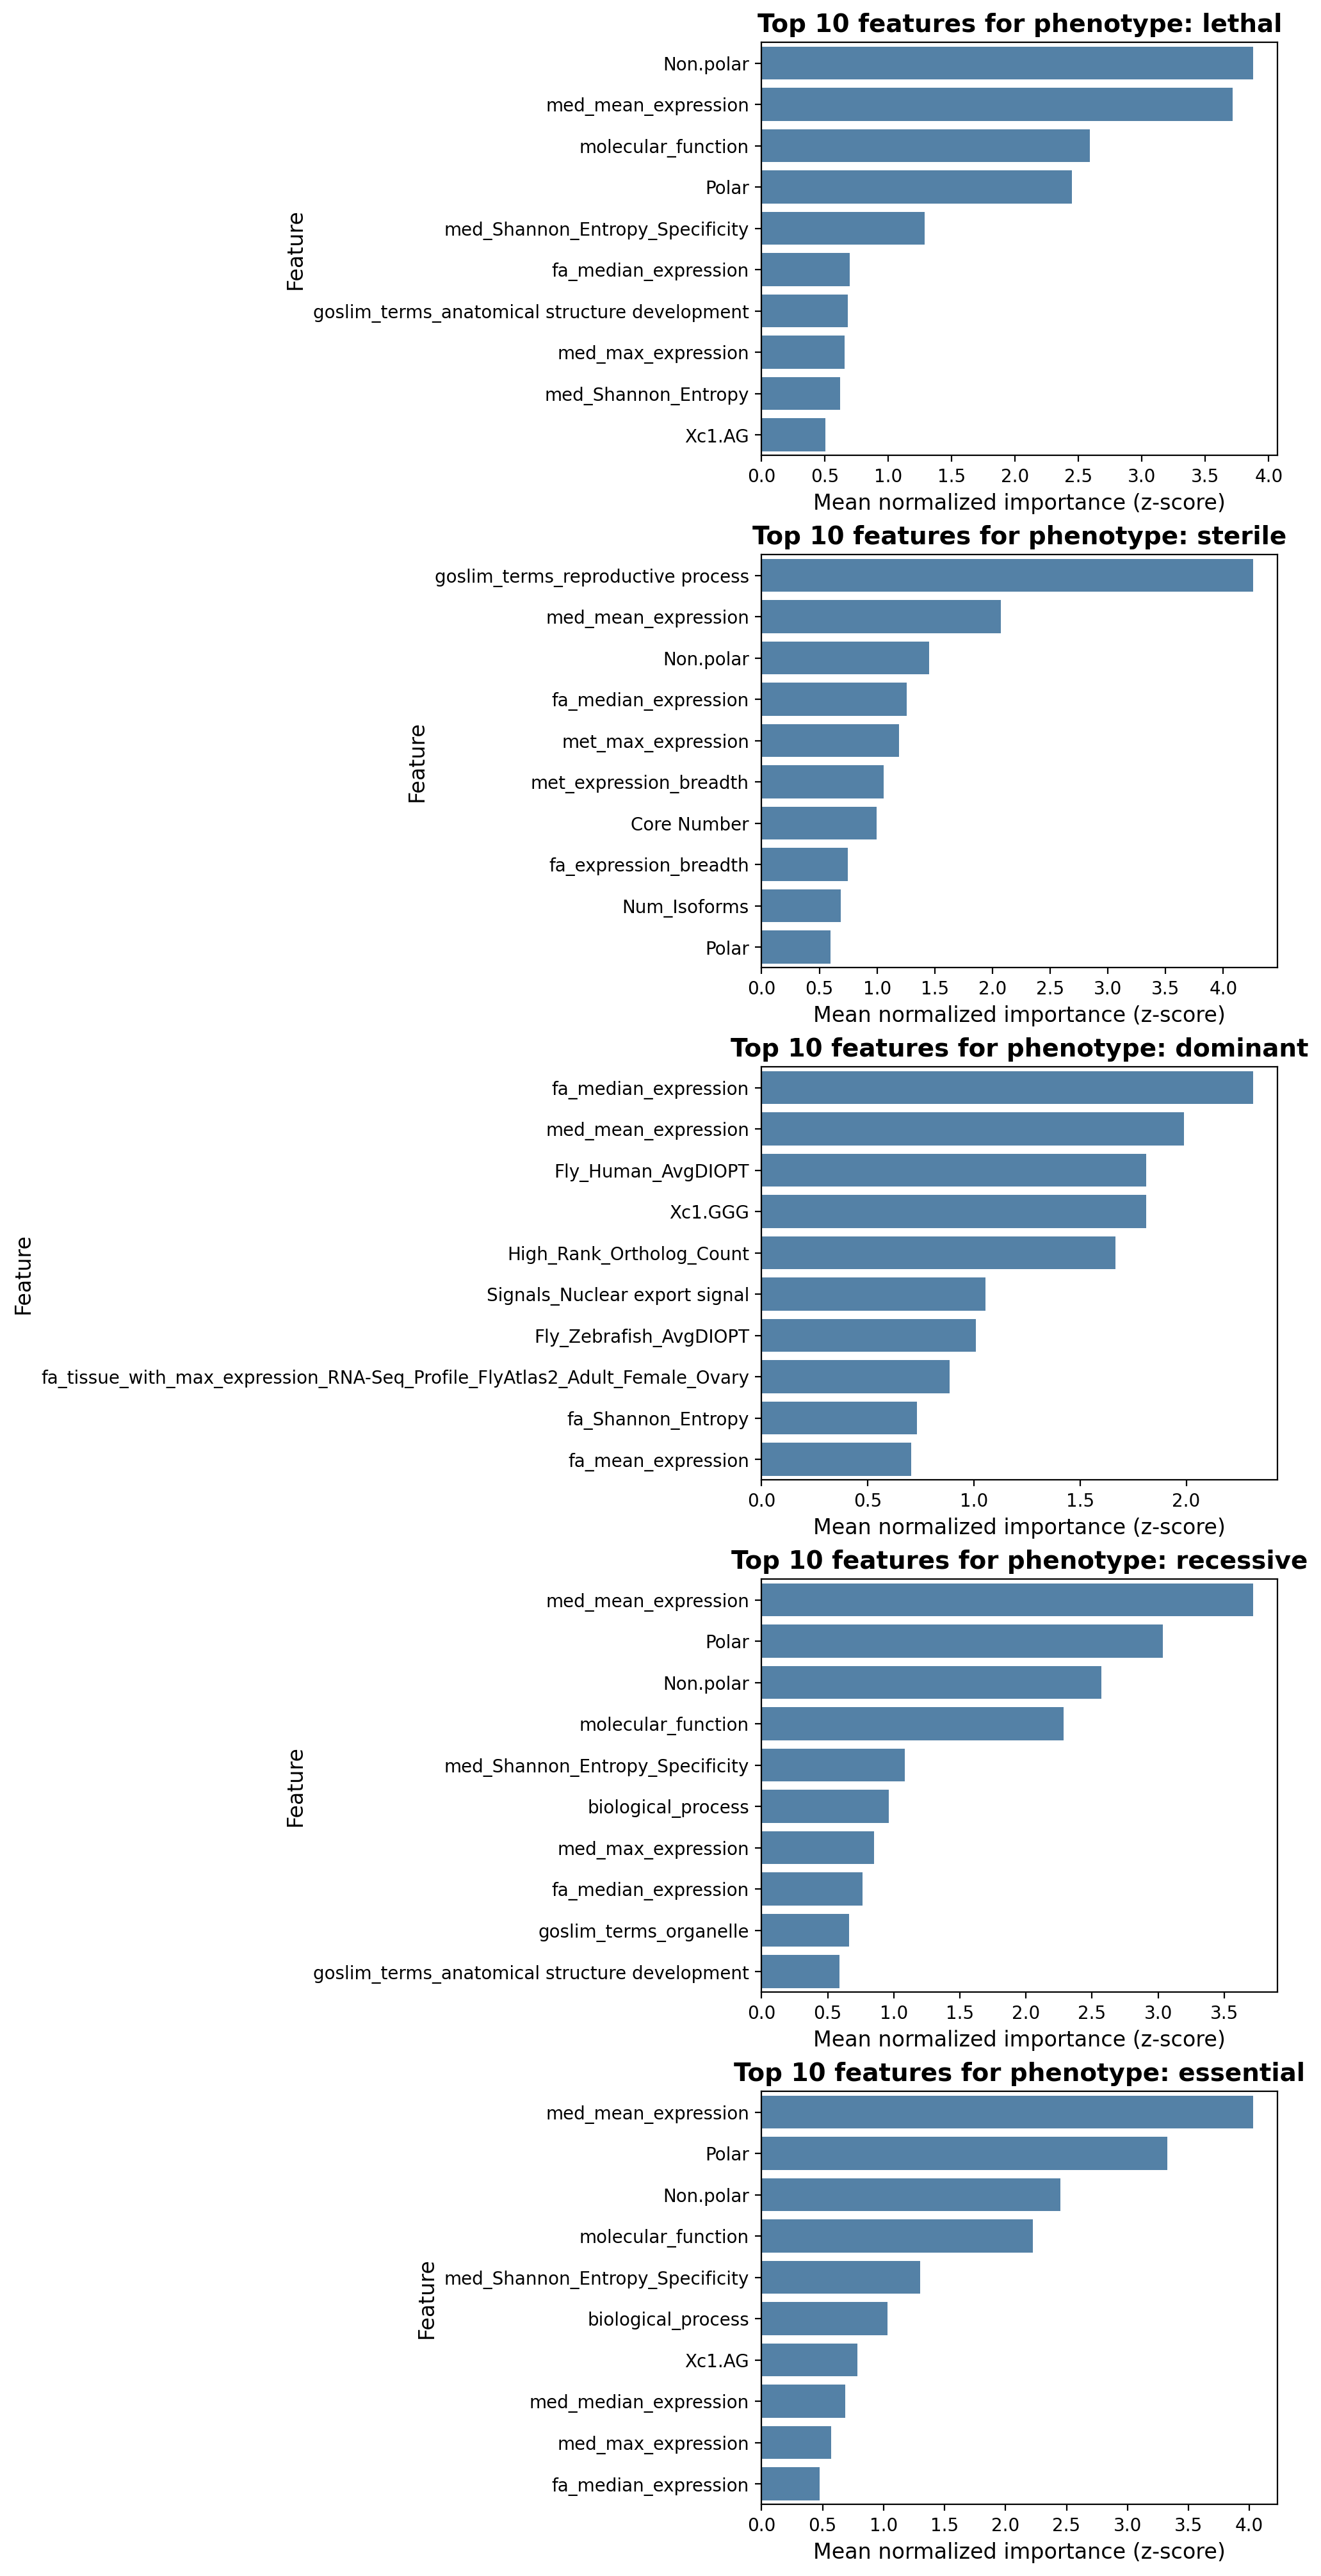

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

classifiers_importances = {
    'rf': rf_per_label_importances,
    'lr': lr_per_label_importances,
    'svm': svm_per_label_importances,
    'gbm': gbm_per_label_importances,
    'xgb': xgb_per_label_importances,
    'mlp': mlp_per_label_importances,
}

phenotypes = ['lethal', 'sterile', 'dominant', 'recessive', 'essential']
top_k = 10

# Increase DPI for higher resolution
fig, axes = plt.subplots(len(phenotypes), 1, figsize=(10, len(phenotypes)*4), constrained_layout=True, dpi=200)

for i, phenotype in enumerate(phenotypes):
    dfs = []
    for clf_name, clf_importances in classifiers_importances.items():
        df = clf_importances[phenotype][['feature', 'importance']].copy()
        df.set_index('feature', inplace=True)
        df.rename(columns={'importance': clf_name}, inplace=True)
        dfs.append(df)

    combined = pd.concat(dfs, axis=1)
    combined_norm = combined.apply(zscore, nan_policy='omit')
    combined_norm['mean_importance'] = combined_norm.mean(axis=1)
    top_features = combined_norm['mean_importance'].nlargest(top_k)

    # Plot on the subplot axis
    sns.barplot(x=top_features.values, y=top_features.index, ax=axes[i], color='steelblue')


    # Set title with bold font and black color
    axes[i].set_title(f'Top {top_k} features for phenotype: {phenotype}', fontweight='bold', color='black', fontsize=14)
    axes[i].set_xlabel('Mean normalized importance (z-score)', color='black', fontsize=12)
    axes[i].set_ylabel('Feature', color='black', fontsize=12)

    # Set tick params color to black for x and y axes
    axes[i].tick_params(axis='x', colors='black')
    axes[i].tick_params(axis='y', colors='black')

    # Save each subplot individually
    fig_single, ax_single = plt.subplots(figsize=(10, 4), dpi=500)
    sns.barplot(x=top_features.values, y=top_features.index, ax=ax_single, color='steelblue')
    ax_single.set_title(f'Top {top_k} features for phenotype: {phenotype}', fontweight='bold', color='black', fontsize=14)
    ax_single.set_xlabel('Mean normalised importance (z-score)', color='black', fontsize=12)
    ax_single.set_ylabel('Feature', color='black', fontsize=12)
    ax_single.tick_params(axis='x', colors='black')
    ax_single.tick_params(axis='y', colors='black')
    plt.tight_layout()
    fig_single.savefig(f'top_features_{phenotype}.png', bbox_inches='tight')
    plt.close(fig_single)

plt.show()

<ipython-input-121-c6cfdef08956>:80: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


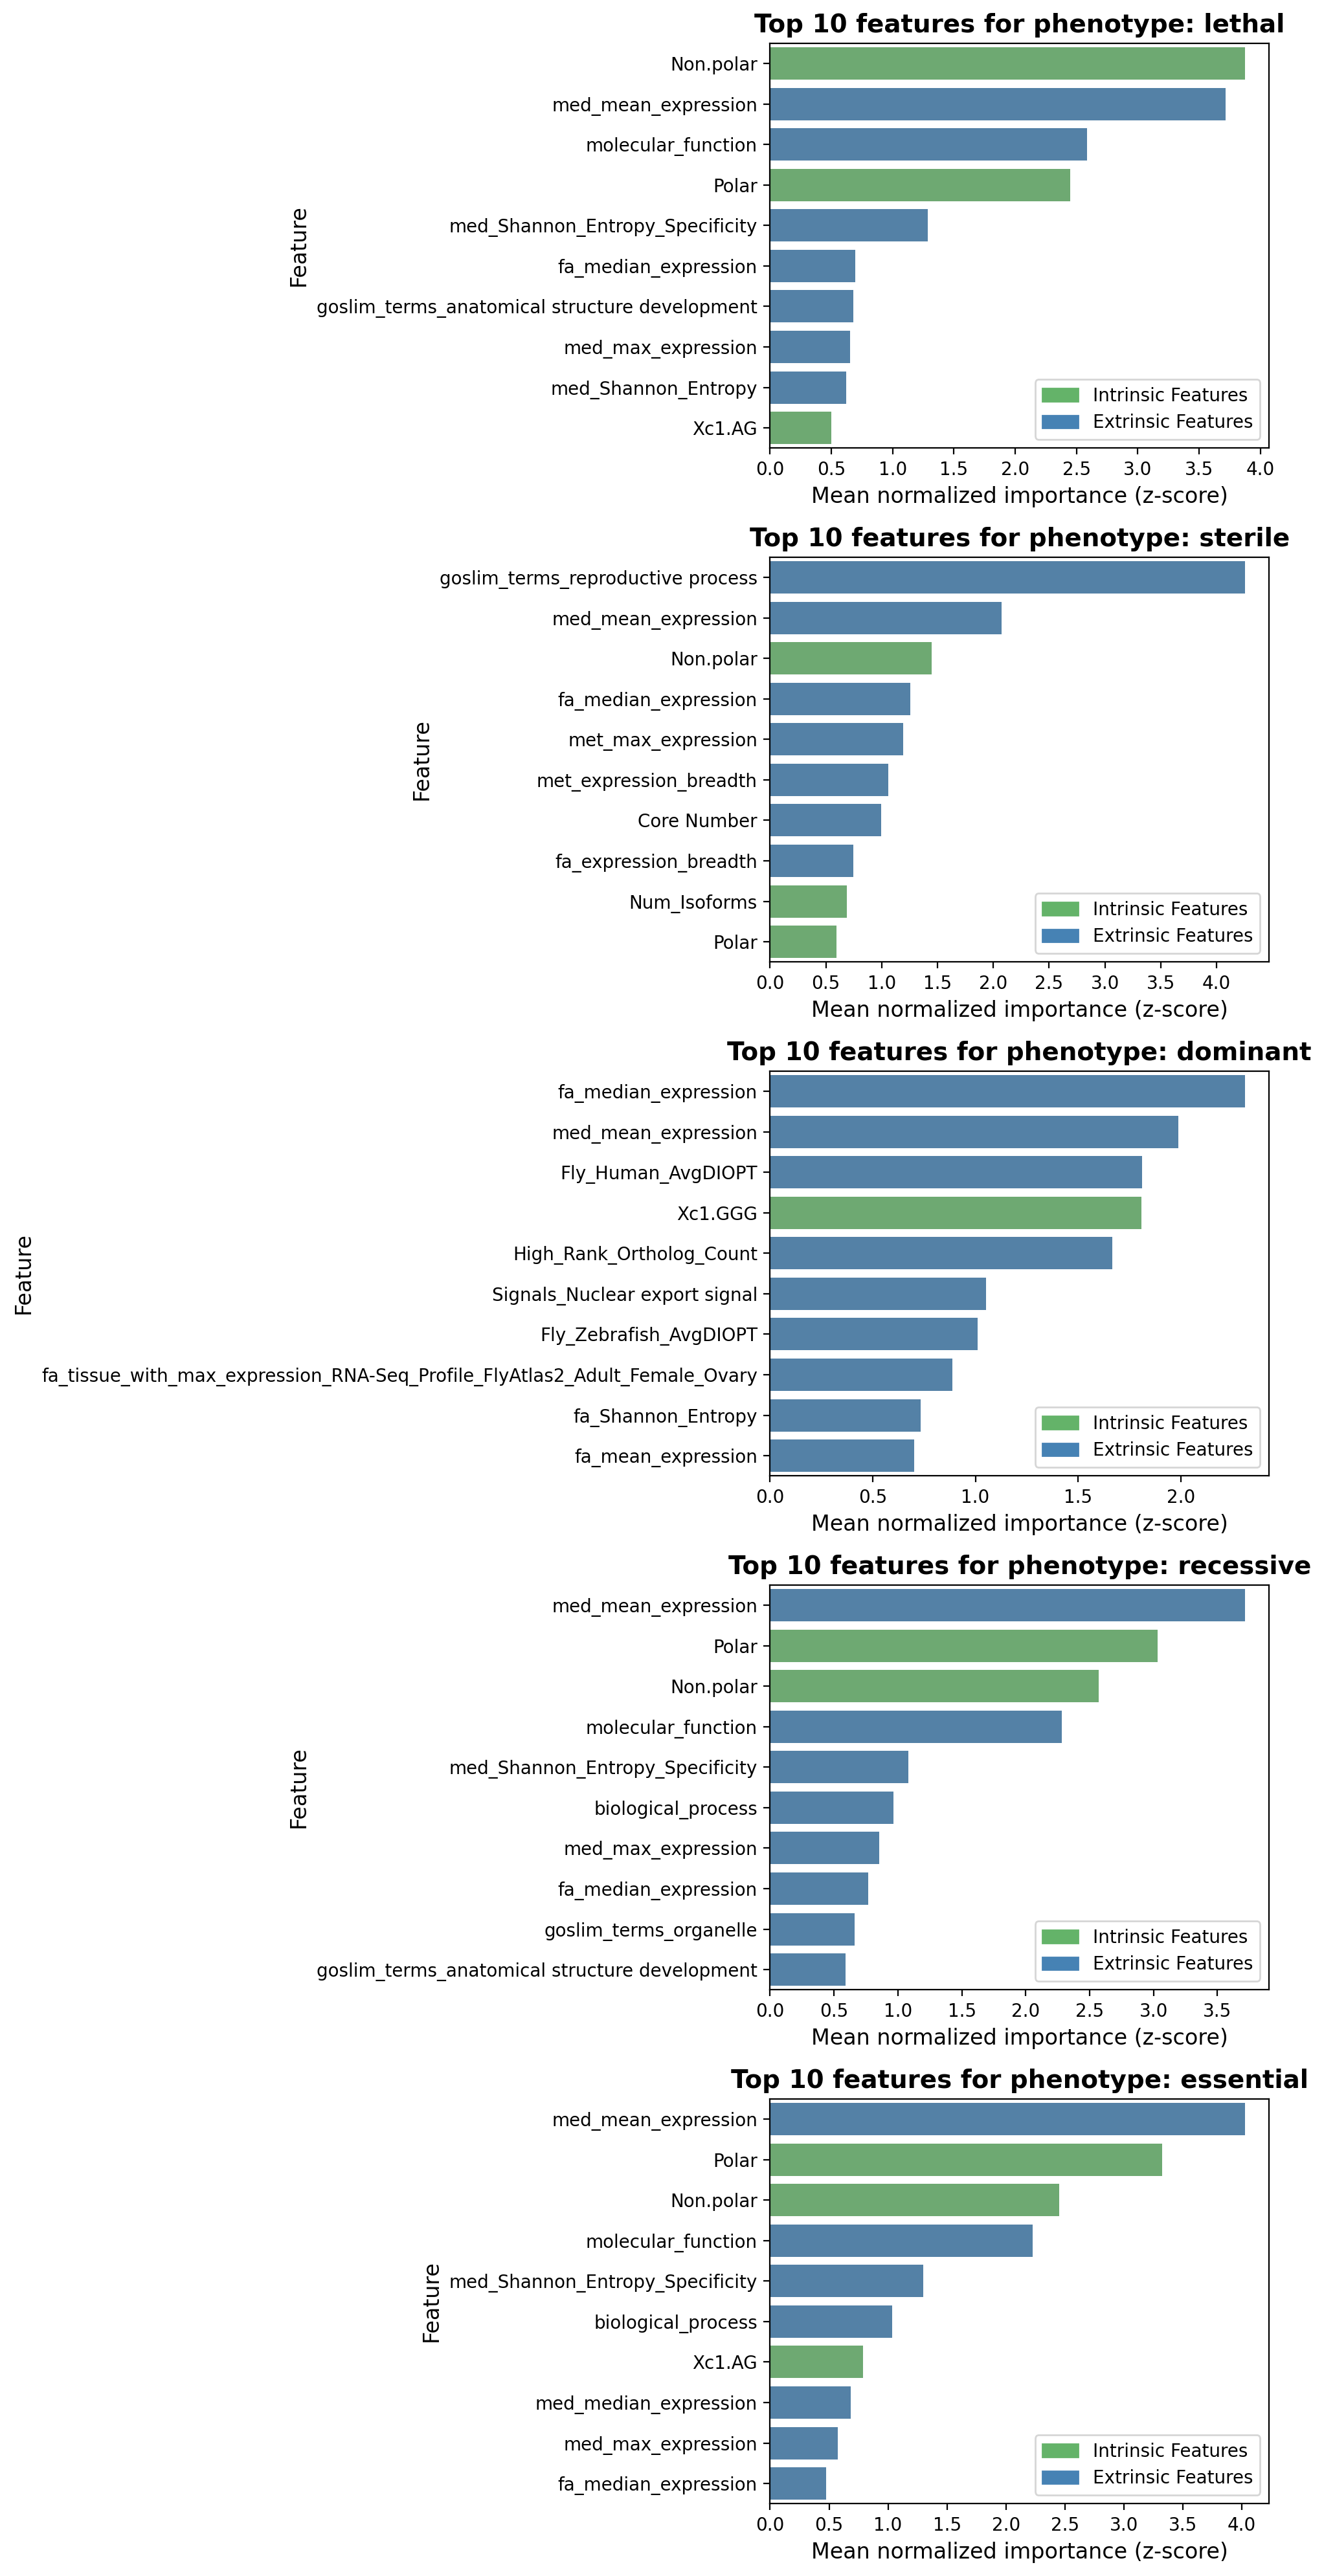

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import matplotlib.patches as mpatches

classifiers_importances = {
    'rf': rf_per_label_importances,
    'lr': lr_per_label_importances,
    'svm': svm_per_label_importances,
    'gbm': gbm_per_label_importances,
    'xgb': xgb_per_label_importances,
    'mlp': mlp_per_label_importances,
}

phenotypes = ['lethal', 'sterile', 'dominant', 'recessive', 'essential']
top_k = 10

# Define intrinsic features here (example names — replace with your actual intrinsic features)
intrinsic_features = {'Non.polar', 'Polar','Xc1.AG', 'Xc1.GGG', 'Num_Isoforms'
}

# Colors for intrinsic and extrinsic
color_map = {True: '#64b369', False: 'steelblue'}

fig, axes = plt.subplots(len(phenotypes), 1, figsize=(10, len(phenotypes)*4), constrained_layout=True, dpi=200)

for i, phenotype in enumerate(phenotypes):
    dfs = []
    for clf_name, clf_importances in classifiers_importances.items():
        df = clf_importances[phenotype][['feature', 'importance']].copy()
        df.set_index('feature', inplace=True)
        df.rename(columns={'importance': clf_name}, inplace=True)
        dfs.append(df)

    combined = pd.concat(dfs, axis=1)
    combined_norm = combined.apply(zscore, nan_policy='omit')
    combined_norm['mean_importance'] = combined_norm.mean(axis=1)
    top_features = combined_norm['mean_importance'].nlargest(top_k)

    # Determine color for each feature based on intrinsic/extrinsic
    bar_colors = [color_map[feat in intrinsic_features] for feat in top_features.index]

    # Plot bars with corresponding colors
    sns.barplot(
        x=top_features.values,
        y=top_features.index,
        ax=axes[i],
        palette=bar_colors
    )

    axes[i].set_title(f'Top {top_k} features for phenotype: {phenotype}', fontweight='bold', color='black', fontsize=14)
    axes[i].set_xlabel('Mean normalized importance (z-score)', color='black', fontsize=12)
    axes[i].set_ylabel('Feature', color='black', fontsize=12)
    axes[i].tick_params(axis='x', colors='black')
    axes[i].tick_params(axis='y', colors='black')

    # Legend for intrinsic/extrinsic colors
    intrinsic_patch = mpatches.Patch(color='#64b369', label='Intrinsic Features')
    extrinsic_patch = mpatches.Patch(color='steelblue', label='Extrinsic Features')
    axes[i].legend(handles=[intrinsic_patch, extrinsic_patch], loc='lower right')

    # Save each subplot individually with the color scheme
    fig_single, ax_single = plt.subplots(figsize=(5, 4), dpi=500)
    sns.barplot(
        x=top_features.values,
        y=top_features.index,
        ax=ax_single,
        palette=bar_colors
    )
    ax_single.set_title(f'Top {top_k} features for phenotype: {phenotype}', fontweight='bold', color='black', fontsize=14)
    ax_single.set_xlabel('Mean normalized importance (z-score)', color='black', fontsize=12)
    ax_single.set_ylabel('Feature', color='black', fontsize=12)
    ax_single.tick_params(axis='x', colors='black')
    ax_single.tick_params(axis='y', colors='black')
    ax_single.legend(handles=[intrinsic_patch, extrinsic_patch], loc='lower right')
    fig_single.savefig(f'top_features_{phenotype}.png', bbox_inches='tight')
    plt.close(fig_single)
    plt.tight_layout()

plt.show()